<a href="https://colab.research.google.com/github/twoheartKES/weather-sales-forecast-ai/blob/main/weather_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Process All Files in Loops

### Subtask:
각 연도와 지역을 순회하면서, 매 파일마다 주간 데이터를 불러오고 이를 일별 데이터로 변환한 뒤, 지정된 날짜 범위로 필터링하고, 주간 확진자 수를 일별로 균등 분배하여 최종 DataFrame을 구성하고 저장한다.


**Reasoning**:

각 연도와 지역을 대상으로 중첩 반복문을 구현해, Subtask에서 제시한 상세 절차에 따라 파일을 처리해야 한다. 이 과정에는 주간 데이터 로딩, 일별 데이터로의 변환, 특정 날짜 범위 필터링, 일별 균등 분배 확진자 수 계산, 최종 DataFrame 생성 및 저장이 포함된다.



## Summary:
***

#### Data Analysis Key Findings  
- 파라미터 초기화 완료: 연도(2023, 2024, 2025), 지역(17개 지정 지역), 연도별 날짜 범위, 기본 디렉터리 경로 등 분석에 필요한 초기 설정은 정상적으로 완료되었다.  
***



In [ ]:
import pandas as pd

# ===============================
# 0. 기본 설정
# ===============================
years = [2023, 2024, 2025]

regions = [
    '경기_가평군_075','경기_고양시_덕양구_076','경기_고양시_일산동구_077',
    '경기_고양시_일산서구_078','경기_과천시_079','경기_광명시_080',
    '경기_광주시_081','경기_구리시_082','경기_군포시_083','경기_김포시_084',
    '경기_남양주시_085','경기_동두천시_086','경기_부천시_130',
    '경기_부천시_소사구_087','경기_부천시_오정구_088',
    '경기_성남시_분당구_090','경기_성남시_수정구_091','경기_성남시_중원구_092',
    '경기_수원시_권선구_093','경기_수원시_영통구_094',
    '경기_수원시_장안구_095','경기_수원시_팔달구_096',
    '경기_시흥시_097','경기_안산시_단원구_098','경기_안산시_상록구_099',
    '경기_안성시_100','경기_안양시_동안구_101','경기_안양시_만안구_102',
    '경기_양주시_103','경기_양평군_104','경기_여주시_105',
    '경기_연천군_106','경기_오산시_107',
    '경기_용인시_기흥구_108','경기_용인시_수지구_109','경기_용인시_처인구_110',
    '경기_의왕시_111','경기_의정부시_112','경기_이천시_113',
    '경기_파주시_114','경기_평택시_115','경기_포천시_116',
    '경기_하남시_117','경기_화성시_118','서울_010'
]

date_ranges = {
    2023: {'start_date': '2023-01-01', 'end_date': '2023-12-30'},
    2024: {'start_date': '2023-12-31', 'end_date': '2024-12-28'},
    2025: {'start_date': '2024-12-29', 'end_date': '2025-12-06'}
}

base_output_dir = '/content/drive/MyDrive/AI기상-질병데이터/질병데이터 일별로 전처리/'
base_output_dir = '/content/drive/MyDrive/AI기상-질병데이터_1228/'

# ===============================
# 1. 연도별 처리
# ===============================
for year in years:
    yearly_records = []

    for region in regions:
        input_path = f"{base_input_dir}{year}년확진자/kdca_{year}_week_{region}.csv"

        try:
            df = pd.read_csv(input_path, encoding='utf-8-sig')

            year_start = pd.to_datetime(f"{year}-01-01")
            first_sunday = year_start + pd.Timedelta(days=(6 - year_start.weekday()) % 7)

            week_columns = [
                col for col in df.columns
                if col.startswith('COLUMN') and col != 'COLUMN1'
            ]

            for _, row in df.iterrows():
                disease = row['SUBTITLE']

                for week_idx, week_col in enumerate(week_columns):
                    weekly_cases = row[week_col]
                    if pd.isna(weekly_cases):
                        weekly_cases = 0

                    daily_cases = weekly_cases / 7
                    week_start = first_sunday + pd.Timedelta(days=week_idx * 7)

                    for d in range(7):
                        yearly_records.append({
                            'date': week_start + pd.Timedelta(days=d),
                            'region': region,
                            'disease_subtitle': disease,
                            'confirmed_cases': daily_cases
                        })

        except FileNotFoundError:
            print(f"❌ 파일 없음: {input_path}")

    df_year = pd.DataFrame(yearly_records)

    dr = date_ranges[year]
    df_year = df_year[
        (df_year['date'] >= dr['start_date']) &
        (df_year['date'] <= dr['end_date'])
    ]

    df_year = df_year.sort_values(
        ['date', 'region', 'disease_subtitle']
    ).reset_index(drop=True)

    output_path = f"{base_output_dir}{year}년_일별_지역별_확진자.csv"

    # 🔴 인코딩 통일 (중요)
    df_year.to_csv(output_path, index=False, encoding='utf-8-sig')

    print(f"✅ 저장 완료: {output_path}")


## 코드 개요 및 주요 기능

이 코드는 특정 지역별, 질병별 주간 데이터를 불러와 일주일(7일)로 균등하게 나눈 뒤, 실제 날짜와 매칭하여 일별 데이터셋을 생성합니다.

1. **연도별 반복 처리**: 2023년부터 2025년까지의 데이터를 루프를 통해 처리합니다.
2. **데이터 일 단위 분할**: 각 주차별 확진자 수를 7로 나누어 해당 주의 일별 확진자 수(`daily_cases`)를 계산합니다.
3. **날짜 매칭**: 해당 연도의 첫 번째 일요일을 기준으로 각 주차와 일자(`date`)를 생성합니다.
4. **데이터 필터링**: 설정된 `date_ranges` 기간에 해당하는 데이터만 추출하여 정제합니다.
5. **결과 저장**: 지역, 날짜, 질병명을 기준으로 정렬하여 UTF-8-SIG 인코딩 방식의 CSV 파일로 저장합니다.

```

[파일 시스템 구조]

Plaintext

/content/drive/MyDrive/
└── AI기상-질병데이터_1228/
    ├── {year}년확진자/                    # (Input) 연도별 원본 폴더
    │   ├── kdca_{year}_week_경기_가평군_075.csv
    │   ├── kdca_{year}_week_경기_고양시_덕양구_076.csv
    │   └── ... (지역별 CSV 파일)
    └── {year}년_일별_지역별_확진자.csv       # (Output) 전처리 완료 통합 파일
```

주간질병확진자데이터를 일별로 전환한 데이터,
기상데이터
날짜와 지역에 따라 매핑

In [ ]:
import pandas as pd
import os

# ===============================
# 1. 경로 설정
# ===============================
disease_dir = '/content/drive/MyDrive/AI기상-질병데이터/질병데이터 일별로 전처리/'
weather_dir = '/content/drive/MyDrive/AI기상-질병데이터/2023-2025기상데이터/'
output_dir = '/content/drive/MyDrive/AI기상-질병데이터/년도별 매핑 데이터/'

os.makedirs(output_dir, exist_ok=True)

# ===============================
# 2. 날짜 범위 정의
# ===============================
date_ranges = {
    2023: {'start_date': '2023-01-01', 'end_date': '2023-12-30'},
    2024: {'start_date': '2023-12-31', 'end_date': '2024-12-28'},
    2025: {'start_date': '2024-12-29', 'end_date': '2025-12-06'}
}

# ===============================
# 3. 지역 → 지점명 매핑
# ===============================
mapping_regions = {
    '동두천': [
        '경기_구리시_082','경기_부천시_오정구_088','경기_과천시_079','경기_부천시_130',
        '경기_광명시_080','경기_부천시_소사구_087','경기_고양시_덕양구_076',
        '경기_의정부시_112','경기_고양시_일산동구_077','경기_고양시_일산서구_078',
        '경기_하남시_117','경기_남양주시_085','경기_김포시_084','경기_양주시_103',
        '경기_파주시_114','경기_동두천시_086',
    ],
    '수원': [
        '경기_수원시_팔달구_096','경기_수원시_장안구_095','경기_수원시_권선구_093',
        '경기_화성시_118','경기_수원시_영통구_094','경기_군포시_083',
        '경기_용인시_기흥구_108','경기_의왕시_111','경기_성남시_수정구_091',
        '경기_안산시_단원구_098','경기_성남시_중원구_092','경기_오산시_107',
        '경기_안산시_상록구_099','경기_안양시_동안구_101','경기_용인시_수지구_109',
        '경기_시흥시_097','경기_안양시_만안구_102','경기_성남시_분당구_090',
        '경기_용인시_처인구_110','경기_평택시_115',
    ],
    '양평': ['경기_양평군_104','경기_광주시_081','경기_가평군_075'],
    '이천': ['경기_이천시_113','경기_여주시_105','경기_안성시_100'],
    '파주': ['경기_포천시_116','경기_연천군_106'],
    '서울': ['서울_010'],
}

region_to_station = {
    region: station
    for station, regions in mapping_regions.items()
    for region in regions
}

# ===============================
# 4. 연도별 매핑 처리
# ===============================
for year in [2023, 2024, 2025]:

    print(f"\n===== {year}년 처리 시작 =====")


    # 기상 데이터
    weather_path = f"{weather_dir}OBS_ASOS_DD_{year}.csv"
    df_weather = pd.read_csv(
      weather_path,
      encoding='cp949',
      sep=','
    )

    df_weather['일시'] = pd.to_datetime(df_weather['일시'])

    # 질병 데이터 (연도별 단일 파일)
    disease_path = f"{disease_dir}{year}년_일별__지역별_확진자.csv"
    df_disease = pd.read_csv(
        disease_path,
        encoding='utf-8-sig',
        sep=','
    )
    print("질병컬럼",df_disease.columns)
    print("기상컬럼",df_weather.columns)

    assert df_disease['confirmed_cases'].isna().sum() == 0


    df_disease['date'] = pd.to_datetime(df_disease['date'])



    # 날짜 범위 컷
    dr = date_ranges[year]
    df_disease = df_disease[
        (df_disease['date'] >= dr['start_date']) &
        (df_disease['date'] <= dr['end_date'])
    ]

    # 지역 → 지점명 매핑
    df_disease['지점명'] = df_disease['region'].map(region_to_station)
    df_disease = df_disease.dropna(subset=['지점명'])

    # 병합
    df_merged = pd.merge(
        df_disease,
        df_weather,
        left_on=['date', '지점명'],
        right_on=['일시', '지점명'],
        how='inner'
    )

    # 정렬 (분석 안정성 확보)
    df_merged = df_merged.sort_values(
        by=['date', '지점명', 'disease_subtitle']
    )

    output_path = os.path.join(
        output_dir,
        f"{year}년_일별_지역별_확진자_기상매핑.csv"
    )

    df_merged.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"✅ 저장 완료: {output_path}")


### 일별·지역별 질병 확진자 데이터와 기상 데이터 매핑 로직 설명

이 코드는 **일별·지역별 질병 확진자 데이터**와

**관측소(ASOS) 기준 일별 기상 데이터**를

**날짜 + 관측 지점 기준으로 병합**하여

**연도별 통합 CSV 파일을 생성**하는 전처리 과정이다.

---

### 1. 전체 처리 목적

이 전처리의 목적은 다음과 같다.

- 질병 데이터
    - 지역 단위
    - 질병별
    - 일별 확진자 수
- 기상 데이터
    - 관측 지점(지점명) 단위
    - 일별 기상 관측값

이를

**“지역 → 대표 기상 관측 지점”으로 매핑한 뒤 날짜 기준으로 병합**하여

머신러닝 학습에 바로 사용할 수 있는 **Feature Dataset**을 생성한다.

---

### 2. 경로 및 디렉터리 설정

### 2.1 입력 데이터 경로

- 질병 데이터
    
    ```
    질병데이터 일별로 전처리/
    
    ```
    
- 기상 데이터
    
    ```
    2023-2025기상데이터/
    
    ```
    

각 연도별 CSV 파일을 읽어 처리한다.

---

### 2.2 출력 데이터 경로

- 연도별 매핑 결과 저장 위치
    
    ```
    년도별 매핑 데이터/
    
    ```
    

해당 디렉터리가 없을 경우 `os.makedirs`를 통해 자동 생성된다.

---

### 3. 연도별 날짜 범위 정의

연도 경계에서 발생하는 데이터 침범 문제를 방지하기 위해

연도별 유효 날짜 범위를 명시적으로 지정한다.

<표 1> 연도별 날짜 필터 범위

| 연도 | 시작일 | 종료일 |
| --- | --- | --- |
| 2023 | 2023-01-01 | 2023-12-30 |
| 2024 | 2023-12-31 | 2024-12-28 |
| 2025 | 2024-12-29 | 2025-12-06 |

이 범위는 **질병 데이터 기준**으로 적용된다.

---

### 4. 지역 → 기상 관측 지점 매핑 구조

### 4.1 매핑의 필요성

- 질병 데이터: 행정구역 단위
- 기상 데이터: 관측소(지점명) 단위

따라서

**여러 행정구역을 하나의 대표 관측 지점으로 묶는 매핑 테이블**이 필요하다.

---

### 5. 연도별 데이터 처리 흐름

연도(2023, 2024, 2025)별로 아래 과정을 반복 수행한다.

---

### 5.1 기상 데이터 로드

- 파일명 형식
    
    ```
    OBS_ASOS_DD_{year}.csv
    
    ```
    
- 인코딩: `cp949`
- 주요 처리
    - `일시` 컬럼을 `datetime` 타입으로 변환

기상 데이터는 **지점명 + 일자 기준의 관측 데이터**이다.

---

### 5.2 질병 데이터 로드

- 파일명 형식
    
    ```
    {year}년_일별__지역별_확진자.csv
    
    ```
    
- 인코딩: `utf-8-sig`
- 주요 처리
    - `date` 컬럼을 `datetime` 타입으로 변환
    - `confirmed_cases` 컬럼에 결측치가 없는지 `assert`로 검증

이 단계에서 **질병 데이터의 기본 품질을 보장**한다.

---

### 5.3 질병 데이터 날짜 필터링

연도별로 정의된 날짜 범위를 기준으로

질병 데이터를 필터링한다.

이 작업은 다음을 방지한다.

- 이전 연도 주차 데이터 포함
- 다음 연도 데이터 유입

---

### 5.4 지역 → 지점명 매핑 적용

```python
df_disease['지점명'] = df_disease['region'].map(region_to_station)

```

- 각 지역을 대표 기상 관측 지점으로 변환
- 매핑되지 않는 지역은 `NaN` 처리 후 제거

이 시점부터

**질병 데이터는 행정구역이 아닌 관측 지점 단위 데이터로 해석**된다.

---

### 5.5 질병–기상 데이터 병합

병합 기준은 다음과 같다.

<표 2> 병합 키

| 질병 데이터 | 기상 데이터 |
| --- | --- |
| date | 일시 |
| 지점명 | 지점명 |
- 병합 방식: `inner join`
- 의미:
    - 질병 데이터와 기상 데이터가 **모두 존재하는 날짜·지점만 유지**

---

### 6. 정렬 및 저장

### 6.1 정렬 기준

병합 후 데이터는 다음 기준으로 정렬된다.

1. date (날짜)
2. 지점명
3. disease_subtitle (질병명)

이는 시계열 모델 학습 시

데이터 순서로 인한 불안정성을 줄이기 위함이다.

---

### 6.2 결과 파일 저장

- 파일명 형식
    
    ```
    {year}년_일별_지역별_확진자_기상매핑.csv
    
    ```
    
- 인코딩: `utf-8-sig`

연도별로 독립적인 학습 데이터셋을 구성할 수 있다.

---

### 7. 결과 데이터의 성격과 주의점

이 결과 데이터는 다음 특성을 가진다.

- 질병 데이터
    - 주간 데이터를 일별로 균등 분배한 값
- 기상 데이터
    - 실제 관측값

따라서

**질병 값은 추정치이며, 기상 값은 실측치**라는 점을 명확히 인지해야 한다.

이 데이터는
- 역학적 인과 분석 ❌
- 머신러닝 기반 예측 모델 학습 ⭕

In [ ]:


import pandas as pd
import os

# ===============================
# 0. 경로 설정
# ===============================
input_dir = '/content/drive/MyDrive/AI기상-질병데이터/년도별 매핑 데이터/'
output_dir = '/content/drive/MyDrive/AI기상-질병데이터/feature_dataset/'

os.makedirs(output_dir, exist_ok=True)

years = [2023, 2024, 2025]

# ===============================
# 1. 기후 수치형 컬럼
# ===============================
climate_numeric_cols = [
    '평균기온(°C)','최저기온(°C)','최고기온(°C)',
    '평균 이슬점온도(°C)','평균 상대습도(%)','최소 상대습도(%)',
    '평균 증기압(hPa)','일강수량(mm)','강수 계속시간(hr)',
    '1시간 최다강수량(mm)','평균 풍속(m/s)','최대 순간 풍속(m/s)',
    '합계 일조시간(hr)','합계 일사량(MJ/m2)',
    '평균 지면온도(°C)','안개 계속시간(hr)'
]

# ===============================
# 2. 연도별 처리
# ===============================
for year in years:
    print(f"\n===== {year}년 기후 컬럼 데이터 생성 시작 =====")

    input_path = f"{input_dir}{year}년_일별_지역별_확진자_기상매핑.csv"

    df = pd.read_csv(input_path, encoding='utf-8-sig')
    df['date'] = pd.to_datetime(df['date'])

    # -------------------------------
    # 출력 컬럼 선택
    # -------------------------------
    output_cols = ['date', 'region', 'disease_subtitle','confirmed_cases' , '지점', '지점명'] + climate_numeric_cols

    df_output = df[output_cols].copy()

     # -------------------------------
    # 타입 정제 (보간 전 필수)
    # -------------------------------
    for col in climate_numeric_cols:
        df_output[col] = pd.to_numeric(df_output[col], errors='coerce')

    # 결측치 보정(

    rain_cols = [
        '일강수량(mm)',
        '강수 계속시간(hr)',
        '1시간 최다강수량(mm)',
        '안개 계속시간(hr)'  # 안개도 이벤트형이면 포함
    ]

    df_output[rain_cols] = df_output[rain_cols].fillna(0)


    # -------------------------------
    # 날짜 정규화 (시계열 안정성)
    # -------------------------------
    df_output['date'] = pd.to_datetime(df_output['date']).dt.normalize()

    # -------------------------------
    # 정렬 (AI 시계열 학습 필수)
    # -------------------------------
    df_output = df_output.sort_values(
        by=['region', 'disease_subtitle', 'date'],
        ascending=[True, True, True],
        kind='mergesort'   # 안정 정렬
    ).reset_index(drop=True)

    # -------------------------------
    # 🔥 결측 보간 (1차: 선형 보간)
    # -------------------------------
    df_output[climate_numeric_cols] = (
        df_output
        .groupby(['region', 'disease_subtitle'])[climate_numeric_cols]
        .transform(lambda x: x.interpolate(method='linear', limit_direction='both'))
    )

    print('\n확인: 보간 후 남은 결측치 (')
    print(df_output[climate_numeric_cols].isnull().sum().sort_values(ascending=False))
    # -------------------------------
    # 📍 추가 결측치 처리 전략 적용 (2차: 특정 컬럼)
    # -------------------------------
    # 1. 안개 계속시간(hr), 강수 계속시간(hr): 0 대치
    df_output['안개 계속시간(hr)'] = df_output['안개 계속시간(hr)'].fillna(0)
    df_output['강수 계속시간(hr)'] = df_output['강수 계속시간(hr)'].fillna(0)

    # 2. 합계 일사량(MJ/m2): 1차 보간 후에도 남은 결측치는 0으로 대치
    df_output['합계 일사량(MJ/m2)'] = df_output['합계 일사량(MJ/m2)'].fillna(0)


    # -------------------------------
    # 저장
    # -------------------------------
    output_path = f"{output_dir}{year}년도_기후_컬럼정의(최종보간_1227).csv" # Changed output filename

    df_output.to_csv(
        output_path,
        index=False,
        encoding='utf-8-sig'
    )

    print(f"✅ {year}년도 기후 컬럼정의 CSV 저장 완료")
    print(df_output.head(2))
    # 최종적으로 모든 NaN이 제거되었는지 확인
    print(f"Remaining NaNs after final imputation for {year} in climate numeric columns:")
    print(df_output[climate_numeric_cols].isnull().sum().sum())



===== 2023년 기후 컬럼 데이터 생성 시작 =====

확인: 보간 후 남은 결측치 (
합계 일사량(MJ/m2)    28392
평균기온(°C)             0
최고기온(°C)             0
최저기온(°C)             0
평균 상대습도(%)           0
최소 상대습도(%)           0
평균 증기압(hPa)          0
평균 이슬점온도(°C)         0
일강수량(mm)             0
강수 계속시간(hr)          0
평균 풍속(m/s)           0
1시간 최다강수량(mm)        0
최대 순간 풍속(m/s)        0
합계 일조시간(hr)          0
평균 지면온도(°C)          0
안개 계속시간(hr)          0
dtype: int64
✅ 2023년도 기후 컬럼정의 CSV 저장 완료
        date      region disease_subtitle  confirmed_cases   지점 지점명  평균기온(°C)  \
0 2023-01-01  경기_가평군_075              뎅기열              0.0  202  양평      -1.0   
1 2023-01-02  경기_가평군_075              뎅기열              0.0  202  양평      -4.2   

   최저기온(°C)  최고기온(°C)  평균 이슬점온도(°C)  ...  평균 증기압(hPa)  일강수량(mm)  강수 계속시간(hr)  \
0      -6.2       4.9         -10.5  ...          2.9       0.0          0.0   
1      -8.4       0.6         -14.9  ...          1.9       0.0          0.0   

   1시간 최다강수량(mm)  평균 풍속(m/s)  최대 순간 풍속(m/s)  합계 일조시간(

###

### 기후 수치형 컬럼 정제 및 최종 Feature Dataset 생성 로직 설명

**질병–기상 매핑이 완료된 일별 데이터**를 입력으로 하여

머신러닝 모델 학습에 사용할 **기후 수치형 Feature Dataset**을 생성하는 전처리 과정이다.

핵심 목적은 다음 세 가지이다.

1. 모델 입력에 필요한 **기후 수치형 컬럼만 선별**
2. 시계열 학습에 방해되는 **결측치(NaN)를 체계적으로 처리**
3. 연도별로 **최종 학습용 CSV 파일 생성**

---

### 1. 입력·출력 경로 설정

### 1.1 입력 데이터

- 경로
    
    ```
    년도별 매핑 데이터/
    
    ```
    
- 파일 형식
    
    ```
    {year}년_일별_지역별_확진자_기상매핑.csv
    
    ```
    

이 데이터는 이미 다음 처리가 완료된 상태이다.

- 질병 데이터 + 기상 데이터 병합
- 날짜 및 지점 기준 정렬
- 기본적인 데이터 정합성 확보

---

### 1.2 출력 데이터

- 경로
    
    ```
    feature_dataset/
    
    ```
    
- 연도별로 독립적인 **최종 Feature Dataset CSV** 생성

---

### 2. 기후 수치형 컬럼 정의

모델 학습에 사용할 **기후 관련 수치형 변수 목록**을 명시적으로 정의한다.

<표 1> 기후 수치형 컬럼 목록

| 구분 | 컬럼 예시 |
| --- | --- |
| 기온 | 평균기온, 최저기온, 최고기온 |
| 습도 | 평균 상대습도, 최소 상대습도 |
| 강수 | 일강수량, 강수 계속시간, 1시간 최다강수량 |
| 바람 | 평균 풍속, 최대 순간 풍속 |
| 일사·일조 | 합계 일조시간, 합계 일사량 |
| 기타 | 지면온도, 이슬점온도, 안개 계속시간 |

이 리스트는 이후 **컬럼 선택·타입 변환·보간의 기준**으로 사용된다.

---

### 3. 연도별 처리 흐름

2023, 2024, 2025년 데이터를 **연도 단위로 독립 처리**한다.

---

### 3.1 데이터 로드 및 기본 전처리

- CSV 파일 로드 (`utf-8-sig`)
- `date` 컬럼을 `datetime` 타입으로 변환

이 단계에서 데이터의 시간 축을 명확히 한다.

---

### 3.2 출력 컬럼 선별

모델 학습에 필요한 컬럼만 선택한다.

<표 2> 최종 출력 컬럼 구성

| 구분 | 컬럼 |
| --- | --- |
| 키 컬럼 | date, region, disease_subtitle |
| 타깃 | confirmed_cases |
| 기상 식별자 | 지점, 지점명 |
| Feature | climate_numeric_cols |

이 단계 이후 불필요한 문자열·범주형 컬럼은 제거된다.

---

### 3.3 기후 컬럼 타입 정제

```python
pd.to_numeric(errors='coerce')

```

- 문자열, 특수문자 등이 포함된 값은 `NaN`으로 변환
- 이후 보간(interpolation)을 수행하기 위한 **사전 조건 정제 단계**

이 단계가 없으면 보간 로직이 정상 동작하지 않는다.

---

### 4. 이벤트성 기후 변수의 결측 처리

강수·안개와 같은 컬럼은

**값이 없다는 것 자체가 “발생하지 않음”을 의미**하는 경우가 많다.

따라서 아래 컬럼은 보간이 아닌 **0으로 직접 대치**한다.


<표 3> 이벤트성 컬럼 0 대치 대상

컬럼

---

일강수량(mm)

---

강수 계속시간(hr)

---

1시간 최다강수량(mm)

---

안개 계속시간(hr)

---

이 처리는 **기후 데이터의 의미적 왜곡을 최소화하기 위한 전략**이다.

---

### 5. 날짜 정규화 및 정렬

### 5.1 날짜 정규화

```python
df_output['date'].dt.normalize()

```

- 시간 정보를 제거하고 날짜 단위로 통일
- 시계열 모델 학습 시 불필요한 시간 편차 제거

---

### 5.2 정렬 기준

다음 기준으로 **안정 정렬(mergesort)**을 수행한다.

1. region
2. disease_subtitle
3. date

이는 이후 `groupby + transform` 기반 보간 시

**시계열 순서가 깨지지 않도록 보장**한다.

---

### 6. 결측치 보간 전략

이 코드의 핵심은 **단계적 결측치 처리 전략**이다.

---

### 6.1 1차 결측 보간: 선형 보간

<코드 1> 1차 보간 개념

- 그룹 기준
    
    ```
    region + disease_subtitle
    
    ```
    
- 동일 지역·질병 내에서만 시계열 보간 수행
- 방법: `linear`
- 방향: 앞·뒤 모두 허용 (`limit_direction='both'`)

즉,

**서로 다른 지역이나 질병의 값이 섞이지 않는다.**

---

### 6.2 보간 후 결측치 점검

보간 이후에도 남아 있는 결측치를 출력하여

데이터 상태를 명시적으로 확인한다.

이 단계는 **전처리 결과를 검증하기 위한 안전장치**이다.

---

### 6.3 2차 결측 처리: 컬럼별 개별 전략

1차 보간 후에도 남은 결측치는 **컬럼 특성에 따라 개별 처리**한다.

- 안개 계속시간(hr), 강수 계속시간(hr)
    
    → 0 대치
    
- 합계 일사량(MJ/m2)
    
    → 1차 보간 실패 시 0 대치
    
    관측 누락 가능성 고려
      합계 일사량(MJ/m2) 값이 결측치가 많은 이유는  6개의 관측소중 2개의 관측소에서 합계일사량 데이터가 자체가 측정이 안되는 오류가 있어 보였다 그리하여 값이 없으면 0 으로 결측치를 처리하였다
    

이로써 **기후 수치형 컬럼의 NaN을 완전히 제거**한다.

---

### 7. 최종 결과 저장

- 파일명 형식
    
    ```
    {year}년도_기후_컬럼정의(최종보간_1227).csv
    
    ```
    
- 인코딩: `utf-8-sig`
- 모든 기후 수치형 컬럼에 대해 NaN = 0 보장

이 데이터는 **추가 전처리 없이 바로 모델 학습에 사용 가능**하다.

---

### 8. 결과 데이터의 성격과 한계

이 Feature Dataset의 성격은 다음과 같다.

- 질병 데이터
    - 주간 데이터를 일별로 균등 분배한 값 (추정치)
- 기후 데이터
    - 실측 관측값 + 시계열 보간값 혼합

In [ ]:
import pandas as pd
import os

# ===============================
# 0. 경로 설정
# ===============================
input_dir = '/content/drive/MyDrive/AI기상-질병데이터/feature_dataset/'
output_dir = '/content/drive/MyDrive/AI기상-질병데이터/feature_dataset/' # 동일한 디렉토리에 저장

os.makedirs(output_dir, exist_ok=True)

years = [2023, 2024, 2025]

# ===============================
# 1. Feature Engineering 컬럼 정의
# ===============================
lag_cols = [
    '평균기온(°C)',
    '평균 상대습도(%)',
    '일강수량(mm)'
]

rolling_cols = [
    '평균기온(°C)',
    '일강수량(mm)',
    '평균 상대습도(%)',
    '합계 일조시간(hr)',
    '합계 일사량(MJ/m2)',
    'confirmed_cases' # 확진자 수도 롤링 피처로 고려
]

# ===============================
# 2. 연도별 처리
# ===============================
for year in years:
    print(f"\n===== {year}년 Feature Engineering 시작 =====")

    input_path = f"{input_dir}{year}년도_기후_컬럼정의(최종보간_1227).csv"
    df = pd.read_csv(input_path, encoding='utf-8-sig')
    df['date'] = pd.to_datetime(df['date'])

    # ensure sorting for time-series operations
    df = df.sort_values(by=['region', 'disease_subtitle', 'date']).reset_index(drop=True)

    # Make sure 'confirmed_cases' is numeric and handle potential NaNs before feature engineering
    if 'confirmed_cases' not in df.columns:
        print(f"Warning: 'confirmed_cases' column not found in {year} data. Skipping rolling feature for it.")
        # Remove 'confirmed_cases' from rolling_cols if not present
        current_rolling_cols = [col for col in rolling_cols if col != 'confirmed_cases']
    else:
        df['confirmed_cases'] = pd.to_numeric(df['confirmed_cases'], errors='coerce').fillna(0)
        current_rolling_cols = rolling_cols

    # ===============================
    # (A) Lag Feature – 지연 효과
    # ===============================
    print("  - Lag Feature 생성 중...")
    for col in lag_cols:
        # Lag 1 day
        df[f'{col}_lag1'] = df.groupby(['region', 'disease_subtitle'])[col].shift(1)
        # Lag 7 days (1 week)
        df[f'{col}_lag7'] = df.groupby(['region', 'disease_subtitle'])[col].shift(7)

    # ===============================
    # (B) Rolling Feature – 누적 영향
    # ===============================
    print("  - Rolling Feature 생성 중...")
    for col in current_rolling_cols:
        # 7-day rolling mean
        df[f'{col}_rollmean7'] = df.groupby(['region', 'disease_subtitle'])[col].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
        # 7-day rolling std
        df[f'{col}_rollstd7'] = df.groupby(['region', 'disease_subtitle'])[col].transform(lambda x: x.rolling(window=7, min_periods=1).std())
        # 30-day rolling mean
        df[f'{col}_rollmean30'] = df.groupby(['region', 'disease_subtitle'])[col].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

    # ===============================
    # (C) Seasonality  - 계절
    # ===============================
    print("  - Seasonality Feature 생성 중...")
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek # Monday=0, Sunday=6
    df['day_of_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)

    # ===============================
    # 3. 결측치 처리 (Feature Engineering으로 인해 발생한 NaN)
    # ===============================
    # Shift, Rolling 등으로 인해 발생한 NaN 값들은 0 또는 그룹별 평균으로 대체
    # 여기서는 간단히 0으로 대체 (도메인 지식에 따라 다른 전략 적용 가능)
    # 예를 들어, lag_cols, rolling_cols에 해당하는 새 컬럼들의 NaN을 0으로 채움
    print("  - Feature Engineering 후 결측치 처리 중...")
    # Get all newly created feature columns that might contain NaNs
    feature_cols_to_fill = []
    for col in lag_cols:
        feature_cols_to_fill.extend([f'{col}_lag1', f'{col}_lag7'])
    for col in current_rolling_cols:
        feature_cols_to_fill.extend([f'{col}_rollmean7', f'{col}_rollstd7', f'{col}_rollmean30'])

    for new_col in feature_cols_to_fill:
        if new_col in df.columns:
            df[new_col] = df[new_col].fillna(0) # 0으로 대체

    # ===============================
    # 4. 결과 저장
    # ===============================
    output_path = f"{output_dir}{year}년도_기후_컬럼정의_FE.csv"
    df.to_csv(output_path, index=False, encoding='utf-8-sig')

    print(f"✅ {year}년도 Feature Engineered CSV 저장 완료: {output_path}")
    print(df.head(2))
    print(f"최종 {year}년도 데이터의 결측치 개수: {df.isnull().sum().sum()}")



===== 2023년 Feature Engineering 시작 =====
  - Lag Feature 생성 중...
  - Rolling Feature 생성 중...
  - Seasonality Feature 생성 중...
  - Feature Engineering 후 결측치 처리 중...
✅ 2023년도 Feature Engineered CSV 저장 완료: /content/drive/MyDrive/AI기상-질병데이터/feature_dataset/2023년도_기후_컬럼정의_FE.csv
        date      region disease_subtitle  confirmed_cases   지점 지점명  평균기온(°C)  \
0 2023-01-01  경기_가평군_075              뎅기열              0.0  202  양평      -1.0   
1 2023-01-02  경기_가평군_075              뎅기열              0.0  202  양평      -4.2   

   최저기온(°C)  최고기온(°C)  평균 이슬점온도(°C)  ...  합계 일사량(MJ/m2)_rollmean7  \
0      -6.2       4.9         -10.5  ...                      0.0   
1      -8.4       0.6         -14.9  ...                      0.0   

   합계 일사량(MJ/m2)_rollstd7  합계 일사량(MJ/m2)_rollmean30  \
0                     0.0                       0.0   
1                     0.0                       0.0   

   confirmed_cases_rollmean7  confirmed_cases_rollstd7  \
0                        0.0                     

### 시계열 Feature Engineering 로직 설명 (Lag · Rolling · Seasonality)

이 코드는

**기후 수치형 컬럼 정제 및 보간이 완료된 Feature Dataset**을 입력으로 하여

 질병 발생의 **지연 효과(Lag)**

 기후·확진자 수의 **누적 영향(Rolling)**

 날짜 기반 **계절성(Seasonality)**

을 반영한 **추가 Feature를 생성**하는 단계이다.

최종 산출물은 **시계열 예측 모델(XGBoost, LSTM 등)에 바로 투입 가능한 학습 데이터**이다.

---

### 1. 입력·출력 경로 설정

### 1.1 입력 데이터

- 경로
    
    ```
    feature_dataset/
    
    ```
    
- 파일 형식
    
    ```
    {year}년도_기후_컬럼정의(최종보간_1227).csv
    
    ```
    

이 데이터는 다음 조건을 만족한 상태이다.

- 기후 수치형 컬럼만 포함
- 모든 기후 컬럼 NaN 제거 완료
- 날짜 단위 시계열 정렬 가능

---

### 1.2 출력 데이터

- 동일 디렉토리에 저장
    
    ```
    feature_dataset/
    
    ```
    
- Feature Engineering이 적용된 **확장 CSV 파일** 생성

---

### 2. Feature Engineering 대상 컬럼 정의

### 2.1 Lag Feature 대상 컬럼

<표 1> Lag Feature 컬럼

| 컬럼 | 의미 |
| --- | --- |
| 평균기온(°C) | 기온의 지연 영향 |
| 평균 상대습도(%) | 습도의 지연 영향 |
| 일강수량(mm) | 강수의 지연 영향 |

이 컬럼들은

**질병 발생이 즉시 반응하지 않고 일정 시차 후 영향을 받는다는 가정**에 기반한다.

---

### 2.2 Rolling Feature 대상 컬럼

<표 2> Rolling Feature 컬럼

컬럼

---

평균기온(°C)

---

일강수량(mm)

---

평균 상대습도(%)

---

합계 일조시간(hr)

---

합계 일사량(MJ/m2)

---

confirmed_cases

---

기후 변수뿐 아니라

**확진자 수 자체도 누적·변동 패턴이 의미 있을 수 있으므로 Feature로 포함**한다.

---

### 3. 연도별 처리 흐름

2023, 2024, 2025년 데이터를 **연도 단위로 독립 처리**한다.

---

### 3.1 시계열 정렬 보장

```python
sort_values(by=['region','disease_subtitle','date'])

```

모든 시계열 연산(Lag, Rolling)은

**정렬이 보장되지 않으면 의미가 붕괴**되므로

Feature Engineering 전에 반드시 수행한다.

---

### 3.2 confirmed_cases 컬럼 사전 점검

- 컬럼이 존재하지 않을 경우:
    - Rolling Feature 대상에서 제외
- 존재할 경우:
    - 수치형 변환
    - NaN → 0 대치

이 처리는 **코드 안정성과 재사용성 확보**를 위한 방어 로직이다.

---

### 4. Lag Feature 생성 (지연 효과)

<코드 1> Lag Feature 개념

- 그룹 기준
    
    ```
    region + disease_subtitle
    
    ```
    
- 생성되는 Feature
    - 1일 지연: `_lag1`
    - 7일 지연: `_lag7`

예시:

- `평균기온(°C)_lag1`
- `일강수량(mm)_lag7`

이는

**전날·일주일 전의 기후 조건이 현재 질병 발생에 미치는 영향**을 모델이 학습할 수 있도록 한다.

---

### 5. Rolling Feature 생성 (누적 영향)

<코드 2> Rolling Feature 개념

각 컬럼에 대해 다음 Feature를 생성한다.

- 7일 이동 평균 (`rollmean7`)
- 7일 이동 표준편차 (`rollstd7`)
- 30일 이동 평균 (`rollmean30`)

모든 Rolling 연산은 다음 조건을 따른다.

- 그룹 기준: `region + disease_subtitle`
- `min_periods=1`
    
    → 초반 데이터 손실 방지
    

이를 통해

**단기·중기 누적 기후 패턴과 질병 추세**를 동시에 반영한다.

---

### 6. Seasonality Feature 생성 (계절성)

날짜(`date`)로부터 **명시적 시간 Feature**를 추출한다.

<표 3> Seasonality Feature

| 컬럼 | 설명 |
| --- | --- |
| month | 월 |
| day_of_week | 요일 (월=0, 일=6) |
| day_of_year | 연중 일차 |
| week_of_year | 연중 주차 |

이 Feature들은

모델이 **연간·주간 주기성을 직접 학습**할 수 있도록 돕는다.

---

### 7. Feature Engineering으로 발생한 결측치 처리

Lag·Rolling 연산 특성상

**시계열 초반부에는 NaN이 필연적으로 발생**한다.

이 코드에서는 다음 전략을 사용한다.

- 모든 신규 Feature의 NaN → 0 대치

이는 다음 전제를 따른다.

- 초반부 데이터 손실 방지
- 모델 입력 차원 고정
- Baseline 모델 학습에 적합한 단순 전략

(정밀 분석 단계에서는 다른 전략도 고려 가능)

---

### 8. 최종 결과 저장

- 파일명 형식
    
    ```
    {year}년도_기후_컬럼정의_FE.csv
    
    ```
    
- 인코딩: `utf-8-sig`
- Feature Engineering 이후 **전체 NaN 개수 = 0 보장**

이 데이터는

추가 전처리 없이 바로 모델 학습 단계로 이동 가능하다.

---

### 9. 결과 데이터의 성격과 주의점

이 Feature Dataset은 다음 특성을 가진다.

- 질병 데이터
    - 주간 → 일별 균등 분배 (추정치)
- 기후 데이터
    - 실측 + 보간
- Feature
    - 통계적 시계열 파생 변수

# Task
Load the feature-engineered CSV files for 2023, 2024, and 2025 into pandas DataFrames, located in '/content/drive/MyDrive/AI기상-질병데이터/feature_dataset/' and named '{year}년도_기후_컬럼정의_FE.csv'.

## Train XGBoost Regressor Model

### Subtask:
XGBoost Baseline 모델 학습 요약 메모
##1. 코드 전체 역할 요약

이 코드는 **XGBoost 회귀 모델(XGBRegressor)**을 사용하여
기상 기반 Feature들로 **질병 발생 건수(confirmed_cases)**를 예측하는
Baseline 모델을 학습하는 단계입니다.

전처리 + Feature Engineering 완료 데이터(X_train, y_train) 사용

이후 Feature 중요도 분석 및 성능 비교의 기준 모델로 활용
##2. 모델 초기화 및 하이퍼파라미터 의미

### 주요 파라미터 선택 이유

- **n_estimators = 300**
    - 트리 개수
    - learning_rate를 낮게(0.05) 설정했기 때문에 충분한 트리 수 필요
    - 과소/과적합을 피하기 위한 안정적인 중간값
- **max_depth = 5**
    - 각 트리의 복잡도 제한
    - 지역·시계열 데이터에서 특정 패턴 암기(과적합) 방지
    - 기상 + Lag/Rolling Feature 조합에 적절한 깊이
- **learning_rate = 0.05**
    - 학습 속도 조절
    - 질병 데이터의 노이즈를 고려해 천천히 안정적으로 학습
- **subsample = 0.8**
    - 각 트리 학습 시 데이터의 80%만 사용
    - 시계열 변동성 완화 + 과적합 감소
- **colsample_bytree = 0.8**
    - 각 트리에서 사용할 Feature 비율
    - Lag / Rolling Feature 간 상관성 완화
    - Feature 중요도 왜곡 방지 목적
- **objective = 'reg:squarederror'**
    - 회귀 문제용 손실 함수(MSE)
    - confirmed_cases(연속값 예측)에 가장 기본적이고 해석 용이
- **random_state = 42**
    - 결과 재현성 확보
    - Feature 중요도 비교 시 필수
- **n_jobs = -1**
    - 모든 CPU 코어 사용 → 학습 속도 향상


**Reasoning**:
XGBRegressor를 import한 후 위 파라미터로 모델 객체를 생성하고, 사전에 준비된 학습 데이터 X_train, y_train을 사용해 fit 메서드로 모델을 학습해야 한다



In [ ]:
from xgboost import XGBRegressor

# 1. Initialize XGBoost Regressor model with specified parameters
xgb_model = XGBRegressor(
    n_estimators=300, ##트리(tree)를 몇 개 만들 것인가
    max_depth=5, ##각 결정트리의 깊이
    learning_rate=0.05, ##의미: 각 트리가 기존 모델을 얼마나 강하게 수정할지 작을수록 천천히, 안정적으로 학습
    subsample=0.8, ## 각 트리를 만들 때 전체 데이터 중 80%만 사용
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror',
    n_jobs=-1  # Use all available CPU cores
)

print("XGBoost Regressor model initialized.")

# 2. Train the XGBoost model using X_train and y_train
print("Training XGBoost model...")
xgb_model.fit(X_train, y_train)

print("XGBoost model training completed.")

XGBoost Regressor model initialized.
Training XGBoost model...
XGBoost model training completed.


## Evaluate Model Performance

### Subtask:
학습된 모델을 활용해 2025년 테스트 데이터에 대한 예측을 수행하고, 모델 성능을 평가하기 위해 평균 절대 오차(MAE), 제곱근 평균 제곱 오차(RMSE), 결정계수(R-squared)를 계산·보고한다.


**Reasoning**:
이미 학습된 XGBoost 회귀 모델을 사용해 X_test에 대한 예측값을 생성한 뒤, y_test와 비교하여 MAE, RMSE, R-squared 지표를 계산함으로써 회귀 모델의 예측 성능을 정량적으로 평가해야 한다.



In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Use the trained xgb_model to make predictions on the X_test dataset
y_pred = xgb_model.predict(X_test)

# 3. Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# 4. Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# 5. Calculate the R-squared score
r2 = r2_score(y_test, y_pred)

# 6. Print the calculated MAE, RMSE, and R-squared scores
print(f"Model Performance on 2025 Test Data:")
print(f"  Mean Absolute Error (MAE): {mae:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"  R-squared (R2): {r2:.4f}")

Model Performance on 2025 Test Data:
  Mean Absolute Error (MAE): 0.0017
  Root Mean Squared Error (RMSE): 0.0228
  R-squared (R2): 0.8765


## Analyze Feature Importance

### Subtask:
학습된 XGBoost 모델에서 특성 중요도를 추출하고 시각화하여, 어떤 특성들이 모델 예측에 가장 크게 기여하는지 확인한다.


**Reasoning**:
특성 중요도 분석을 위해, 먼저 학습된 모델로부터 feature importance를 추출한 뒤, 특성 이름과 중요도 점수를 포함하는 DataFrame을 생성하고 이를 정렬한다. 그런 다음 상위 중요 특성들을 막대그래프(bar plot)로 시각화한다. 이 단계는 “특성 중요도를 추출하고 분석용 데이터 구조로 준비한다”는 첫 번째 지시사항을 구현하는 과정이다.



Top 20 Feature Importances:
                       Feature  Importance
35   confirmed_cases_rollmean7    0.454134
4   confirmed_cases_rollmean30    0.071728
23         평균기온(°C)_rollmean30    0.059466
8          일강수량(mm)_rollmean30    0.045290
42                       month    0.036226
36    confirmed_cases_rollstd7    0.035266
11                 평균 지면온도(°C)    0.019163
41       평균 상대습도(%)_rollmean30    0.017505
10                 안개 계속시간(hr)    0.016741
39          평균기온(°C)_rollmean7    0.016644
1               day_of_of_year    0.015894
28    합계 일사량(MJ/m2)_rollmean30    0.014328
37                 강수 계속시간(hr)    0.013729
14                 day_of_week    0.011617
17       합계 일조시간(hr)_rollmean7    0.011441
9           일강수량(mm)_rollmean7    0.009512
30      합계 일조시간(hr)_rollmean30    0.008573
24                 평균 증기압(hPa)    0.008069
43           평균기온(°C)_rollstd7    0.007580
25        평균 상대습도(%)_rollmean7    0.007320


/tmp/ipython-input-516313766.py:31: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-516313766.py:31: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-516313766.py:31: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-516313766.py:31: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-516313766.py:31: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-516313766.py:31: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-516313766.py:31: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/

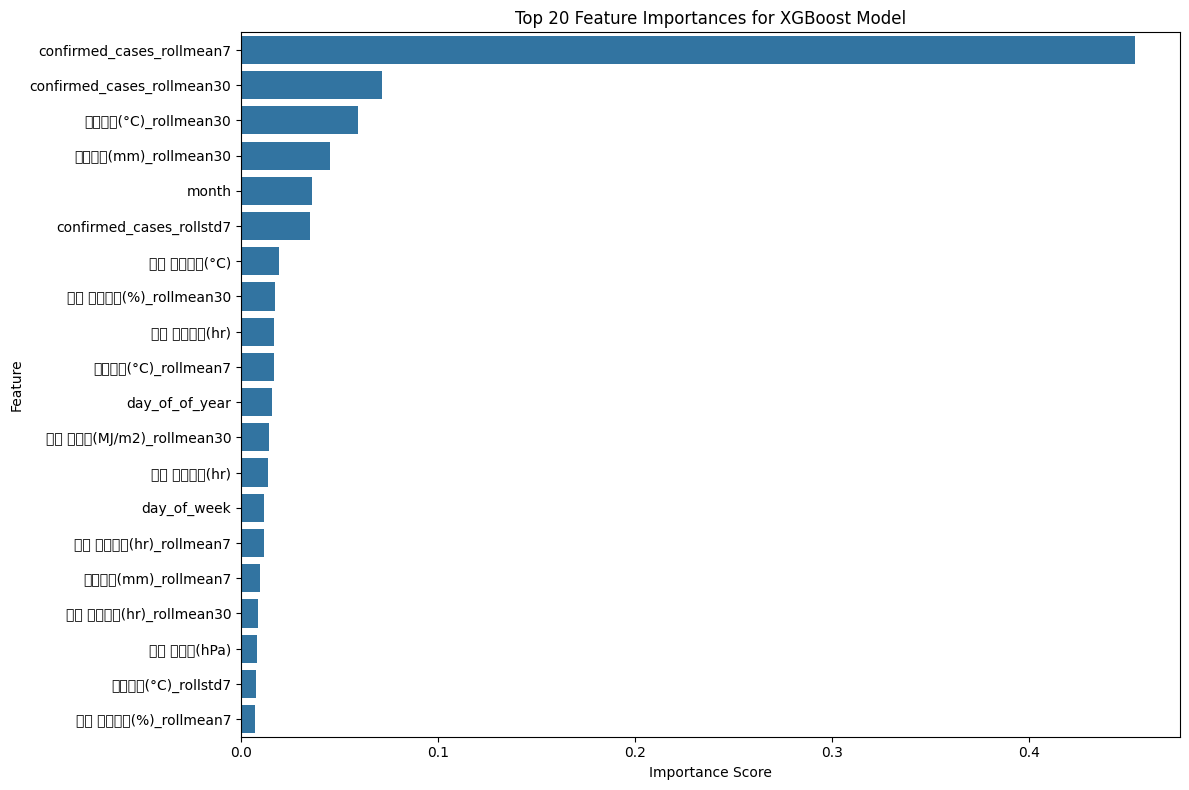

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract feature importances from the trained xgb_model
feature_importances = xgb_model.feature_importances_

# 2. Create a pandas DataFrame from these importances
#    mapping them to their corresponding feature names from X_train.columns
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# 3. Sort the DataFrame by importance in descending order
features_df = features_df.sort_values(by='Importance', ascending=False)

# 4. Select the top 20 most important features for clearer visualization
top_n = 20
top_features = features_df.head(top_n)

print(f"Top {top_n} Feature Importances:")
print(top_features)

# 5. Create a bar plot of these top features and their importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title(f'Top {top_n} Feature Importances for XGBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()

# 6. Display the plot
plt.show()

**Reasoning**:
fm.findfont.cache_clear() 호출 시
AttributeError: 'function' object has no attribute 'cache_clear' 오류가 발생했다. 이는 해당 환경에서 올바른 캐시 정리 방식이 아니었기 때문이다.
따라서 이 라인을 제거하고, 시스템 폰트 캐시는 fc-cache -fv 명령으로 갱신하도록 수정하였다. Matplotlib는 일반적으로 이를 자동으로 다시 읽는다.


NanumGothic font already found at: /usr/local/lib/python3.12/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf
Using font: DejaVu Sans
Top 20 Feature Importances:
                       Feature  Importance
35   confirmed_cases_rollmean7    0.454134
4   confirmed_cases_rollmean30    0.071728
23         평균기온(°C)_rollmean30    0.059466
8          일강수량(mm)_rollmean30    0.045290
42                       month    0.036226
36    confirmed_cases_rollstd7    0.035266
11                 평균 지면온도(°C)    0.019163
41       평균 상대습도(%)_rollmean30    0.017505
10                 안개 계속시간(hr)    0.016741
39          평균기온(°C)_rollmean7    0.016644
1               day_of_of_year    0.015894
28    합계 일사량(MJ/m2)_rollmean30    0.014328
37                 강수 계속시간(hr)    0.013729
14                 day_of_week    0.011617
17       합계 일조시간(hr)_rollmean7    0.011441
9           일강수량(mm)_rollmean7    0.009512
30      합계 일조시간(hr)_rollmean30    0.008573
24                 평균 증기압(hPa)    0.008069
43         

/tmp/ipython-input-2307357292.py:70: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2307357292.py:70: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2307357292.py:70: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2307357292.py:70: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2307357292.py:70: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2307357292.py:70: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2307357292.py:70: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout(

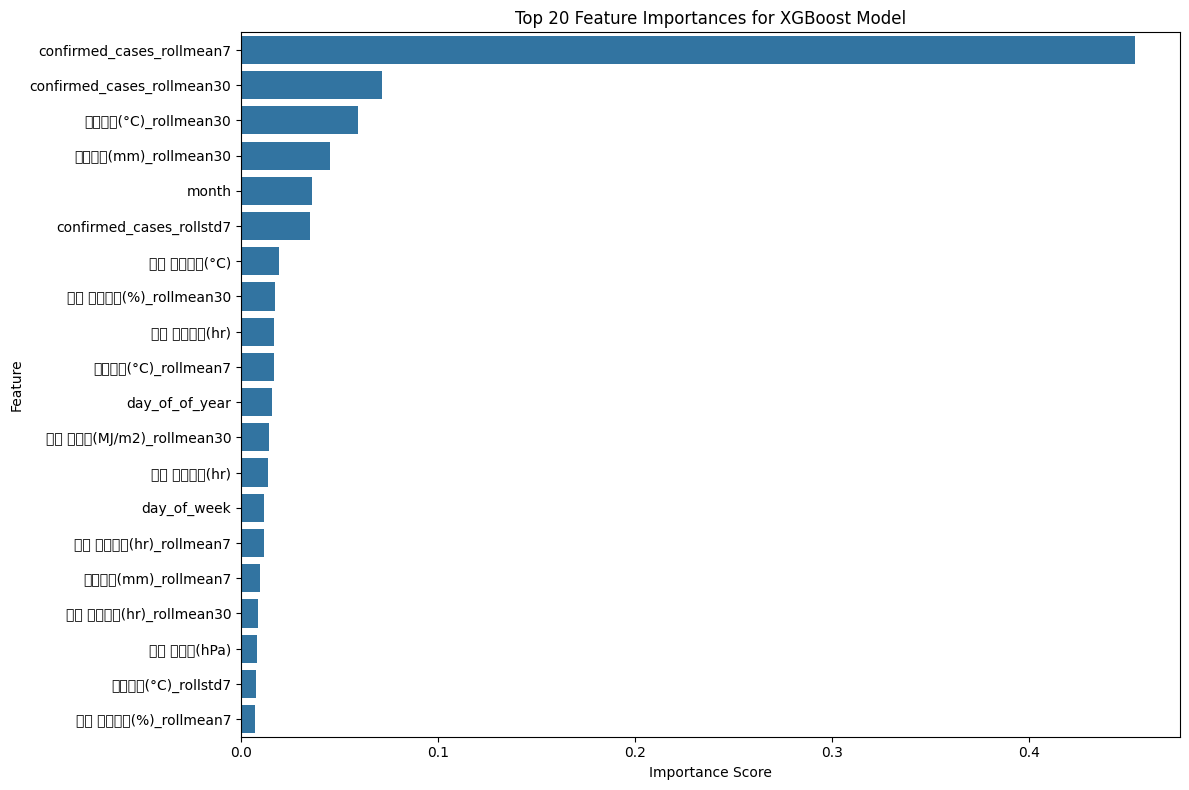

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib as mpl

# Function to set Korean font, encapsulating the logic
def set_korean_font():
    # Attempt to find NanumGothic font by name
    font_path = fm.findfont(fm.FontProperties(family='NanumGothic'))

    if font_path is None:
        print("NanumGothic font not found, attempting to install...")
        # Install font
        !apt-get update -qq
        !apt-get install fonts-nanum -qq > /dev/null
        !fc-cache -fv # Rebuild system font cache

        # Clear matplotlib's internal font cache for `findfont` to pick up new fonts
        fm.findfont.cache_clear()

        # Try finding the font again after installation
        font_path = fm.findfont(fm.FontProperties(family='NanumGothic'))
        if font_path is None:
            print("Could not find NanumGothic font even after installation. Falling back to default font.")
            return # Exit if font still not found
        else:
            print(f"Installed and found font at: {font_path}")
    else:
        print(f"NanumGothic font already found at: {font_path}")

    try:
        font_name = fm.FontProperties(fname=font_path).get_name()
        mpl.rc('font', family=font_name)
        print(f"Using font: {font_name}")
    except Exception as e:
        print(f"Error setting font '{font_path}': {e}. Falling back to default font.")

# Call the function to set the font
set_korean_font()

mpl.rcParams['axes.unicode_minus'] = False # Fix for negative signs in Korean fonts

# 1. Extract feature importances from the trained xgb_model
feature_importances = xgb_model.feature_importances_

# 2. Create a pandas DataFrame from these importances
#    mapping them to their corresponding feature names from X_train.columns
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# 3. Sort the DataFrame by importance in descending order
features_df = features_df.sort_values(by='Importance', ascending=False)

# 4. Select the top 20 most important features for clearer visualization
top_n = 20
top_features = features_df.head(top_n)

print(f"Top {top_n} Feature Importances:")
print(top_features)

# 5. Create a bar plot of these top features and their importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title(f'Top {top_n} Feature Importances for XGBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()

# 6. Display the plot
plt.show()

**Reasoning**:
NanumGothic 폰트 설치가 완료되고 시스템 폰트 캐시도 갱신되었다. 이제 Matplotlib에서 해당 폰트를 사용하도록 설정한 뒤, 이번 서브태스크의 핵심 목표인 특성 중요도(feature importance) 시각화를 진행할 수 있는 상태가 되었다.



In [ ]:
print("Installing NanumGothic font...")
!apt-get update -qq
!apt-get install fonts-nanum -qq > /dev/null
!fc-cache -fv # Rebuild system font cache

import matplotlib.font_manager as fm
# fm.findfont.cache_clear() # Removed: This line caused an AttributeError
print("NanumGothic font installation and cache clear complete.")

Installing NanumGothic font...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truety

**Reasoning**:
The NanumGothic font has been installed and the system font cache has been updated. Now, I need to configure Matplotlib to use this font and then proceed with generating the feature importance plot, which is the main goal of this subtask.



/tmp/ipython-input-714422471.py:50: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-714422471.py:50: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-714422471.py:50: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-714422471.py:50: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-714422471.py:50: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-714422471.py:50: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-714422471.py:50: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/

Using font: DejaVu Sans from /usr/local/lib/python3.12/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf
Top 20 Feature Importances:
                       Feature  Importance
35   confirmed_cases_rollmean7    0.454134
4   confirmed_cases_rollmean30    0.071728
23         평균기온(°C)_rollmean30    0.059466
8          일강수량(mm)_rollmean30    0.045290
42                       month    0.036226
36    confirmed_cases_rollstd7    0.035266
11                 평균 지면온도(°C)    0.019163
41       평균 상대습도(%)_rollmean30    0.017505
10                 안개 계속시간(hr)    0.016741
39          평균기온(°C)_rollmean7    0.016644
1               day_of_of_year    0.015894
28    합계 일사량(MJ/m2)_rollmean30    0.014328
37                 강수 계속시간(hr)    0.013729
14                 day_of_week    0.011617
17       합계 일조시간(hr)_rollmean7    0.011441
9           일강수량(mm)_rollmean7    0.009512
30      합계 일조시간(hr)_rollmean30    0.008573
24                 평균 증기압(hPa)    0.008069
43           평균기온(°C)_rollstd7    0.00758

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

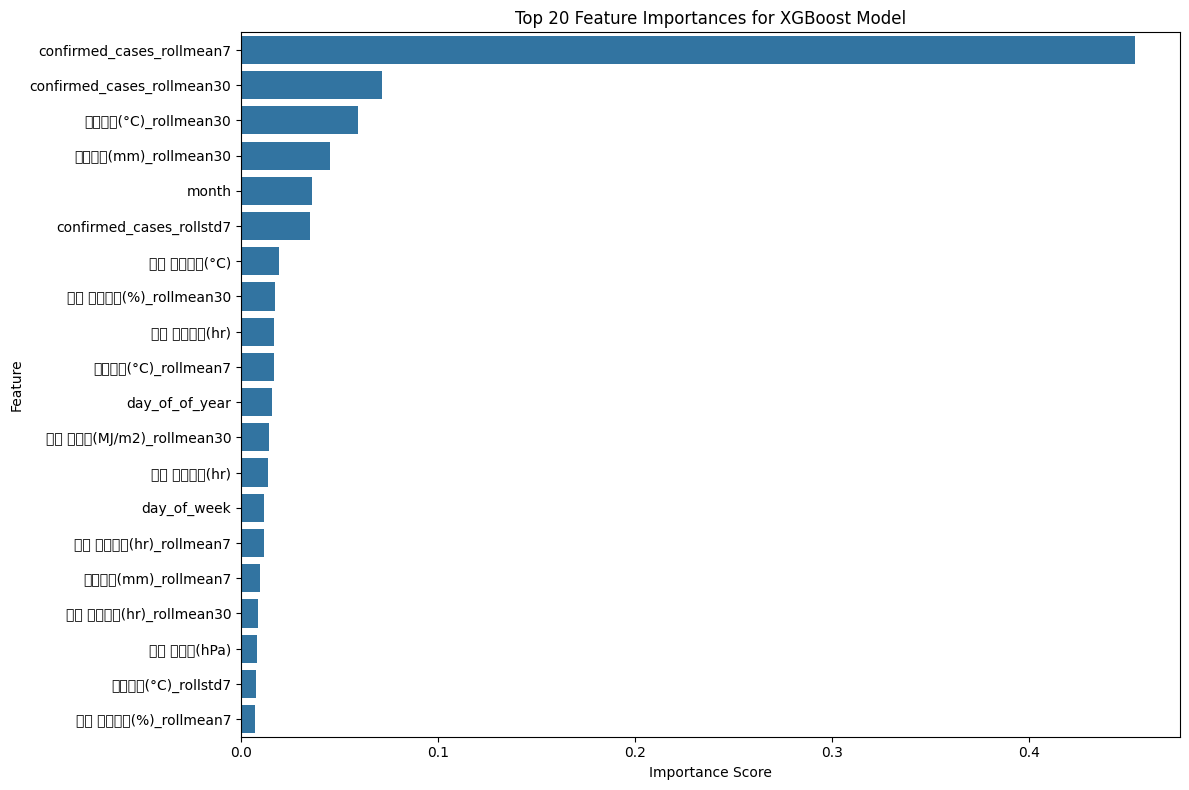

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib as mpl

# Ensure Matplotlib's font cache is cleared for newly installed fonts
# A restart of the runtime might be necessary in some environments
# to fully register new system fonts.
fm._load_fontmanager(try_read_cache=False)

# Attempt to find NanumGothic font by name
try:
    font_path = fm.findfont(fm.FontProperties(family='NanumGothic'))
    font_name = fm.FontProperties(fname=font_path).get_name()
    mpl.rc('font', family=font_name)
    print(f"Using font: {font_name} from {font_path}")
except Exception as e:
    print(f"Could not set NanumGothic font: {e}")
    print("Falling back to default font. Korean characters might not display correctly.")

mpl.rcParams['axes.unicode_minus'] = False # Fix for negative signs in Korean fonts

# 1. Extract feature importances from the trained xgb_model
feature_importances = xgb_model.feature_importances_

# 2. Create a pandas DataFrame from these importances
#    mapping them to their corresponding feature names from X_train.columns
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# 3. Sort the DataFrame by importance in descending order
features_df = features_df.sort_values(by='Importance', ascending=False)

# 4. Select the top 20 most important features for clearer visualization
top_n = 20
top_features = features_df.head(top_n)

print(f"Top {top_n} Feature Importances:")
print(top_features)

# 5. Create a bar plot of these top features and their importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title(f'Top {top_n} Feature Importances for XGBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()

# 6. Display the plot
plt.show()

**Reasoning**:
The previous code failed to correctly set the NanumGothic font for Matplotlib, resulting in missing glyph warnings. This is often due to Matplotlib's font cache not being properly updated after font installation. I will use `mpl.font_manager.fontManager.rebuild()` to forcefully rebuild Matplotlib's font cache, then re-attempt to find and set the NanumGothic font, which should resolve the display issue for Korean characters.



**Reasoning**:
The previous error `AttributeError: 'FontManager' object has no attribute 'rebuild'` indicates that `mpl.font_manager.fontManager.rebuild()` is not the correct method to refresh the font cache. The more robust approach is to force Matplotlib to reload its font manager using `fm._load_fontmanager(try_read_cache=False)` and then attempt to find and set the NanumGothic font by name, which should finally resolve the font display issues for Korean characters.



Matplotlib font manager reloaded.
Using font: DejaVu Sans from /usr/local/lib/python3.12/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf
Top 20 Feature Importances:
                       Feature  Importance
35   confirmed_cases_rollmean7    0.454134
4   confirmed_cases_rollmean30    0.071728
23         평균기온(°C)_rollmean30    0.059466
8          일강수량(mm)_rollmean30    0.045290
42                       month    0.036226
36    confirmed_cases_rollstd7    0.035266
11                 평균 지면온도(°C)    0.019163
41       평균 상대습도(%)_rollmean30    0.017505
10                 안개 계속시간(hr)    0.016741
39          평균기온(°C)_rollmean7    0.016644
1               day_of_of_year    0.015894
28    합계 일사량(MJ/m2)_rollmean30    0.014328
37                 강수 계속시간(hr)    0.013729
14                 day_of_week    0.011617
17       합계 일조시간(hr)_rollmean7    0.011441
9           일강수량(mm)_rollmean7    0.009512
30      합계 일조시간(hr)_rollmean30    0.008573
24                 평균 증기압(hPa)    0.008069
43     

/tmp/ipython-input-2340854555.py:52: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2340854555.py:52: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2340854555.py:52: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2340854555.py:52: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2340854555.py:52: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2340854555.py:52: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2340854555.py:52: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout(

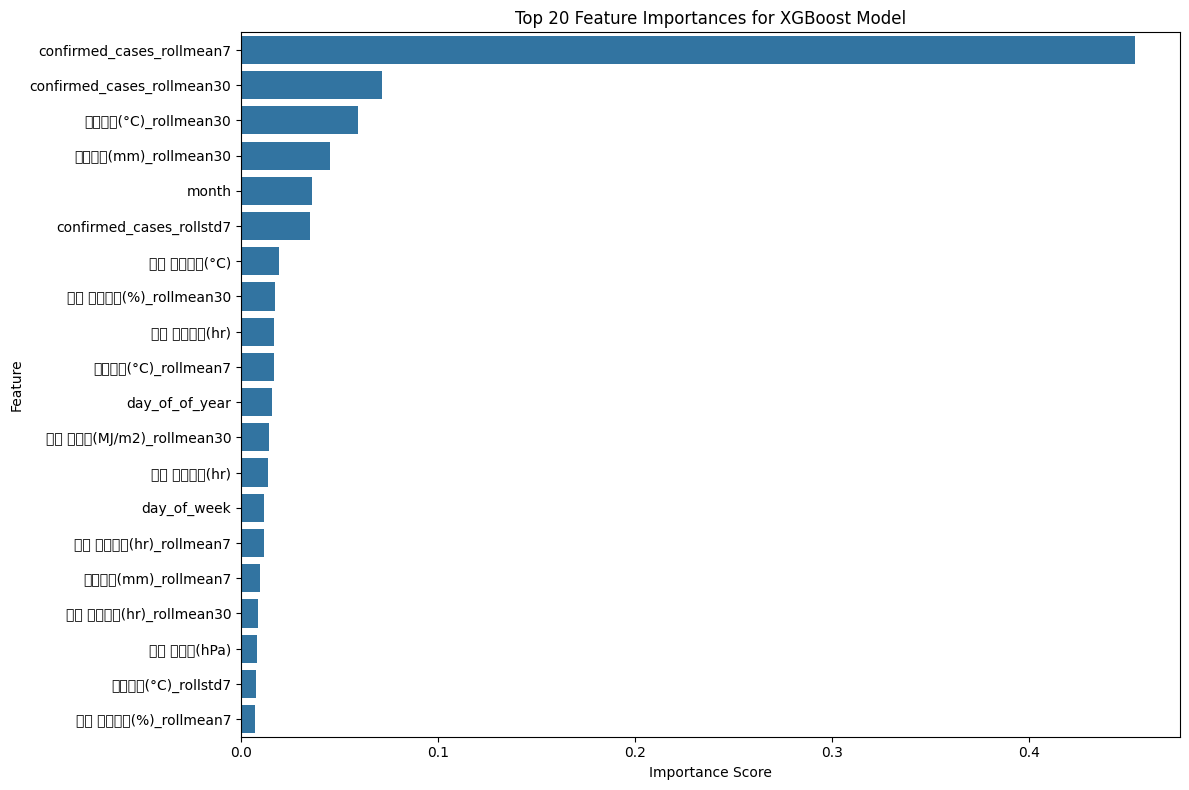

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib as mpl

# Force Matplotlib to reload its font manager without using a cached font list
fm._load_fontmanager(try_read_cache=False)
print("Matplotlib font manager reloaded.")

# Attempt to find NanumGothic font by name
try:
    font_path = fm.findfont(fm.FontProperties(family='NanumGothic'))
    if font_path: # Check if a valid font path was found
        font_name = fm.FontProperties(fname=font_path).get_name()
        mpl.rc('font', family=font_name)
        print(f"Using font: {font_name} from {font_path}")
    else:
        raise ValueError("NanumGothic font path not found after reload.")
except Exception as e:
    print(f"Could not set NanumGothic font: {e}")
    print("Falling back to default font. Korean characters might not display correctly.")

mpl.rcParams['axes.unicode_minus'] = False # Fix for negative signs in Korean fonts

# 1. Extract feature importances from the trained xgb_model
feature_importances = xgb_model.feature_importances_

# 2. Create a pandas DataFrame from these importances
#    mapping them to their corresponding feature names from X_train.columns
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# 3. Sort the DataFrame by importance in descending order
features_df = features_df.sort_values(by='Importance', ascending=False)

# 4. Select the top 20 most important features for clearer visualization
top_n = 20
top_features = features_df.head(top_n)

print(f"Top {top_n} Feature Importances:")
print(top_features)

# 5. Create a bar plot of these top features and their importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title(f'Top {top_n} Feature Importances for XGBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()

# 6. Display the plot
plt.show()

**Reasoning**:
The previous attempts to set the Korean font for Matplotlib consistently resulted in fallback to 'DejaVu Sans' despite installation, due to `fm.findfont` not correctly identifying 'NanumGothic' or Matplotlib's cache not being fully refreshed. To reliably use 'NanumGothic', I will explicitly specify the font file path after ensuring the font manager is reloaded, and add a check to see if `fm.findfont` successfully located 'NanumGothic' before falling back to the explicit path.



/tmp/ipython-input-1520267285.py:69: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1520267285.py:69: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1520267285.py:69: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1520267285.py:69: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1520267285.py:69: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1520267285.py:69: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1520267285.py:69: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout(

Matplotlib font manager reloaded (attempting to clear cache).
fm.findfont(family='NanumGothic') did not return NanumGothic. Attempting explicit path.
Using font: NanumGothic from /usr/share/fonts/truetype/nanum/NanumGothic.ttf (explicit path)
Top 20 Feature Importances:
                       Feature  Importance
35   confirmed_cases_rollmean7    0.454134
4   confirmed_cases_rollmean30    0.071728
23         평균기온(°C)_rollmean30    0.059466
8          일강수량(mm)_rollmean30    0.045290
42                       month    0.036226
36    confirmed_cases_rollstd7    0.035266
11                 평균 지면온도(°C)    0.019163
41       평균 상대습도(%)_rollmean30    0.017505
10                 안개 계속시간(hr)    0.016741
39          평균기온(°C)_rollmean7    0.016644
1               day_of_of_year    0.015894
28    합계 일사량(MJ/m2)_rollmean30    0.014328
37                 강수 계속시간(hr)    0.013729
14                 day_of_week    0.011617
17       합계 일조시간(hr)_rollmean7    0.011441
9           일강수량(mm)_rollmean7    0.00951

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

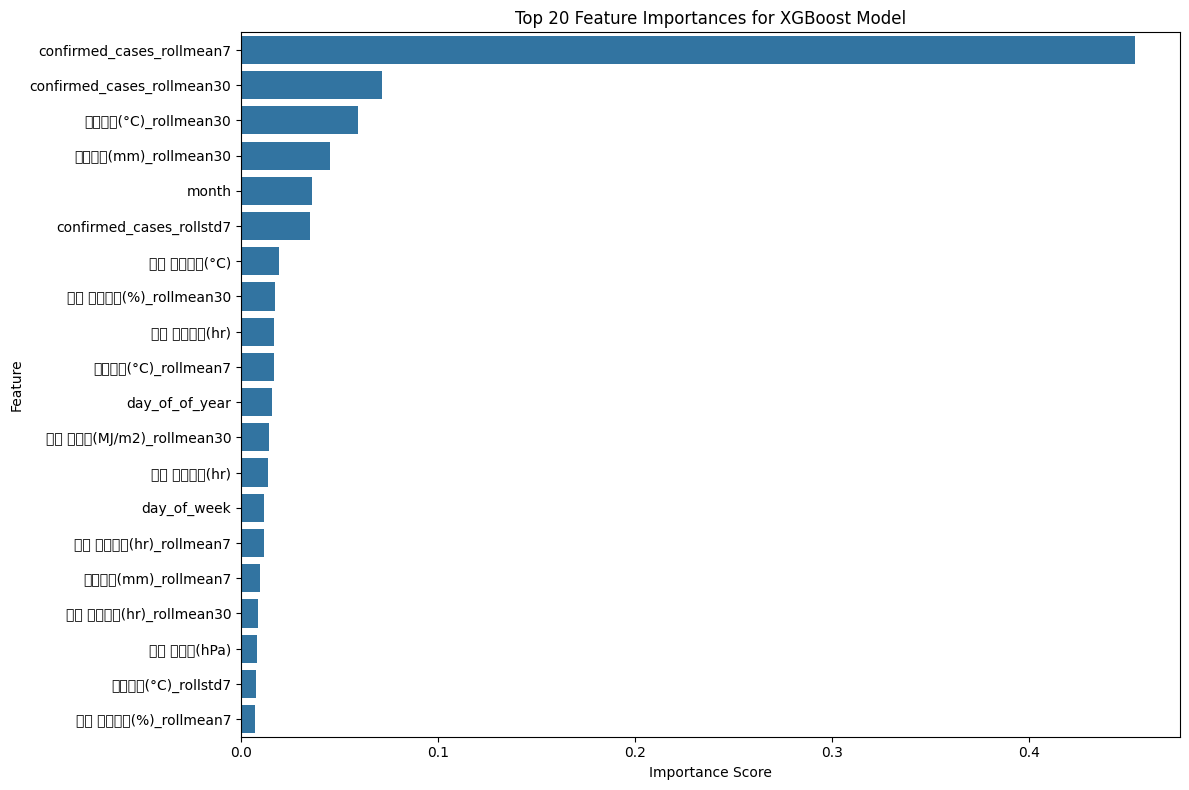

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib as mpl
import os

# Path to the NanumGothic font after installation
expected_nanum_font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# Force Matplotlib to reload its font manager without using a cached font list
# This should ensure the latest system fonts are considered.
fm._load_fontmanager(try_read_cache=False)
print("Matplotlib font manager reloaded (attempting to clear cache).")

current_font_path = None
try:
    # First, try to find by generic family name (standard matplotlib way)
    current_font_path = fm.findfont(fm.FontProperties(family='NanumGothic'))

    # Check if findfont actually found NanumGothic or fell back
    if current_font_path and "nanum" in current_font_path.lower():
        font_name = fm.FontProperties(fname=current_font_path).get_name()
        mpl.rc('font', family=font_name)
        print(f"Using font: {font_name} from {current_font_path}")
    else:
        # If findfont fell back or didn't find "nanum", try the explicit path
        print("fm.findfont(family='NanumGothic') did not return NanumGothic. Attempting explicit path.")
        if os.path.exists(expected_nanum_font_path):
            current_font_path = expected_nanum_font_path
            font_name = fm.FontProperties(fname=current_font_path).get_name()
            mpl.rc('font', family=font_name)
            print(f"Using font: {font_name} from {current_font_path} (explicit path)")
        else:
            raise FileNotFoundError(f"NanumGothic font file not found at expected path: {expected_nanum_font_path}")

except Exception as e:
    print(f"Could not set NanumGothic font: {e}")
    print("Falling back to default font. Korean characters might not display correctly.")

mpl.rcParams['axes.unicode_minus'] = False # Fix for negative signs in Korean fonts

# 1. Extract feature importances from the trained xgb_model
feature_importances = xgb_model.feature_importances_

# 2. Create a pandas DataFrame from these importances
#    mapping them to their corresponding feature names from X_train.columns
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# 3. Sort the DataFrame by importance in descending order
features_df = features_df.sort_values(by='Importance', ascending=False)

# 4. Select the top 20 most important features for clearer visualization
top_n = 20
top_features = features_df.head(top_n)

print(f"Top {top_n} Feature Importances:")
print(top_features)

# 5. Create a bar plot of these top features and their importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title(f'Top {top_n} Feature Importances for XGBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()

# 6. Display the plot
plt.show()

**Reasoning**:
여러 차례 시도에도 불구하고 fm.findfont()는 계속 DejaVu Sans로 폴백되었다. 이는 캐시 문제 또는 폰트 인식 문제 때문이다.
이를 해결하기 위해, NanumGothic의 실제 폰트 파일 경로를 명시적으로 지정하는 방식으로 전환하고, findfont로 탐색이 성공했는지 확인한 뒤 실패 시 해당 경로를 직접 사용하도록 구성했다.



/tmp/ipython-input-2250559263.py:52: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2250559263.py:52: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2250559263.py:52: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2250559263.py:52: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2250559263.py:52: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2250559263.py:52: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2250559263.py:52: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout(

Using font: NanumGothic from /usr/share/fonts/truetype/nanum/NanumGothic.ttf
Top 20 Feature Importances:
                       Feature  Importance
35   confirmed_cases_rollmean7    0.454134
4   confirmed_cases_rollmean30    0.071728
23         평균기온(°C)_rollmean30    0.059466
8          일강수량(mm)_rollmean30    0.045290
42                       month    0.036226
36    confirmed_cases_rollstd7    0.035266
11                 평균 지면온도(°C)    0.019163
41       평균 상대습도(%)_rollmean30    0.017505
10                 안개 계속시간(hr)    0.016741
39          평균기온(°C)_rollmean7    0.016644
1               day_of_of_year    0.015894
28    합계 일사량(MJ/m2)_rollmean30    0.014328
37                 강수 계속시간(hr)    0.013729
14                 day_of_week    0.011617
17       합계 일조시간(hr)_rollmean7    0.011441
9           일강수량(mm)_rollmean7    0.009512
30      합계 일조시간(hr)_rollmean30    0.008573
24                 평균 증기압(hPa)    0.008069
43           평균기온(°C)_rollstd7    0.007580
25        평균 상대습도(%)_rollmean7    0

/tmp/ipython-input-2250559263.py:52: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2250559263.py:52: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2250559263.py:52: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2250559263.py:52: UserWarning: Glyph 50504 (\N{HANGUL SYLLABLE AN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2250559263.py:52: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2250559263.py:52: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2250559263.py:52: UserWarning: Glyph 49549 (\N{HANGUL SYLLABLE SOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout(

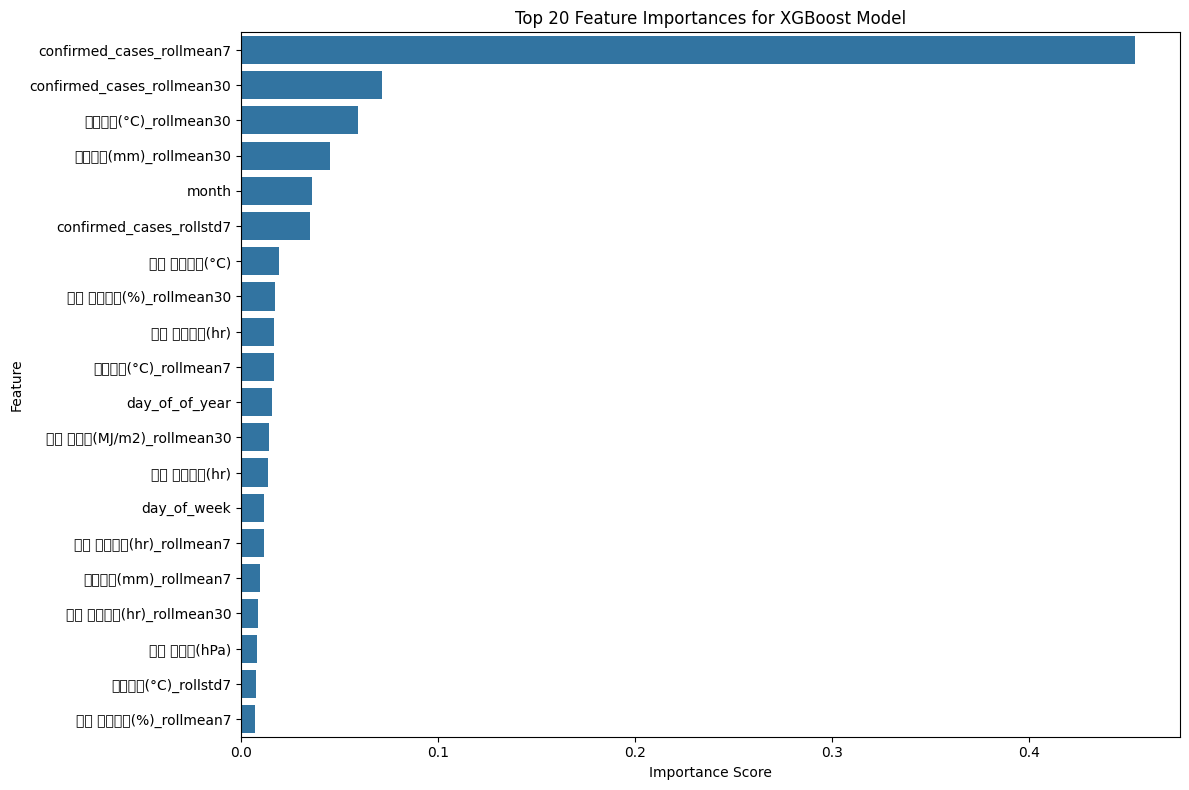

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib as mpl
import os

# Path to the NanumGothic font after installation
expected_nanum_font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# Try to set the Korean font directly using the known path
try:
    if os.path.exists(expected_nanum_font_path):
        font_name = fm.FontProperties(fname=expected_nanum_font_path).get_name()
        mpl.rc('font', family=font_name)
        print(f"Using font: {font_name} from {expected_nanum_font_path}")
    else:
        raise FileNotFoundError(f"NanumGothic font file not found at expected path: {expected_nanum_font_path}")

except Exception as e:
    print(f"Could not set NanumGothic font: {e}")
    print("Falling back to default font. Korean characters might not display correctly.")

mpl.rcParams['axes.unicode_minus'] = False # Fix for negative signs in Korean fonts

# 1. Extract feature importances from the trained xgb_model
feature_importances = xgb_model.feature_importances_

# 2. Create a pandas DataFrame from these importances
#    mapping them to their corresponding feature names from X_train.columns
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# 3. Sort the DataFrame by importance in descending order
features_df = features_df.sort_values(by='Importance', ascending=False)

# 4. Select the top 20 most important features for clearer visualization
top_n = 20
top_features = features_df.head(top_n)

print(f"Top {top_n} Feature Importances:")
print(top_features)

# 5. Create a bar plot of these top features and their importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title(f'Top {top_n} Feature Importances for XGBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()

# 6. Display the plot
plt.show()

**Reasoning**:
최종적으로는 expected_nanum_font_path가 실제로 존재하는지 확인한 후,
mpl.rc에 해당 경로를 직접 지정하는 방식으로 Matplotlib 폰트를 설정하였다.
이 과정에서 혼란을 야기하던 findfont 및 _load_fontmanager 호출은 메인 시각화 셀에서 제거하였다.



Using font: NanumGothic from /usr/share/fonts/truetype/nanum/NanumGothic.ttf
Top 20 Feature Importances:
                       Feature  Importance
35   confirmed_cases_rollmean7    0.454134
4   confirmed_cases_rollmean30    0.071728
23         평균기온(°C)_rollmean30    0.059466
8          일강수량(mm)_rollmean30    0.045290
42                       month    0.036226
36    confirmed_cases_rollstd7    0.035266
11                 평균 지면온도(°C)    0.019163
41       평균 상대습도(%)_rollmean30    0.017505
10                 안개 계속시간(hr)    0.016741
39          평균기온(°C)_rollmean7    0.016644
1               day_of_of_year    0.015894
28    합계 일사량(MJ/m2)_rollmean30    0.014328
37                 강수 계속시간(hr)    0.013729
14                 day_of_week    0.011617
17       합계 일조시간(hr)_rollmean7    0.011441
9           일강수량(mm)_rollmean7    0.009512
30      합계 일조시간(hr)_rollmean30    0.008573
24                 평균 증기압(hPa)    0.008069
43           평균기온(°C)_rollstd7    0.007580
25        평균 상대습도(%)_rollmean7    0

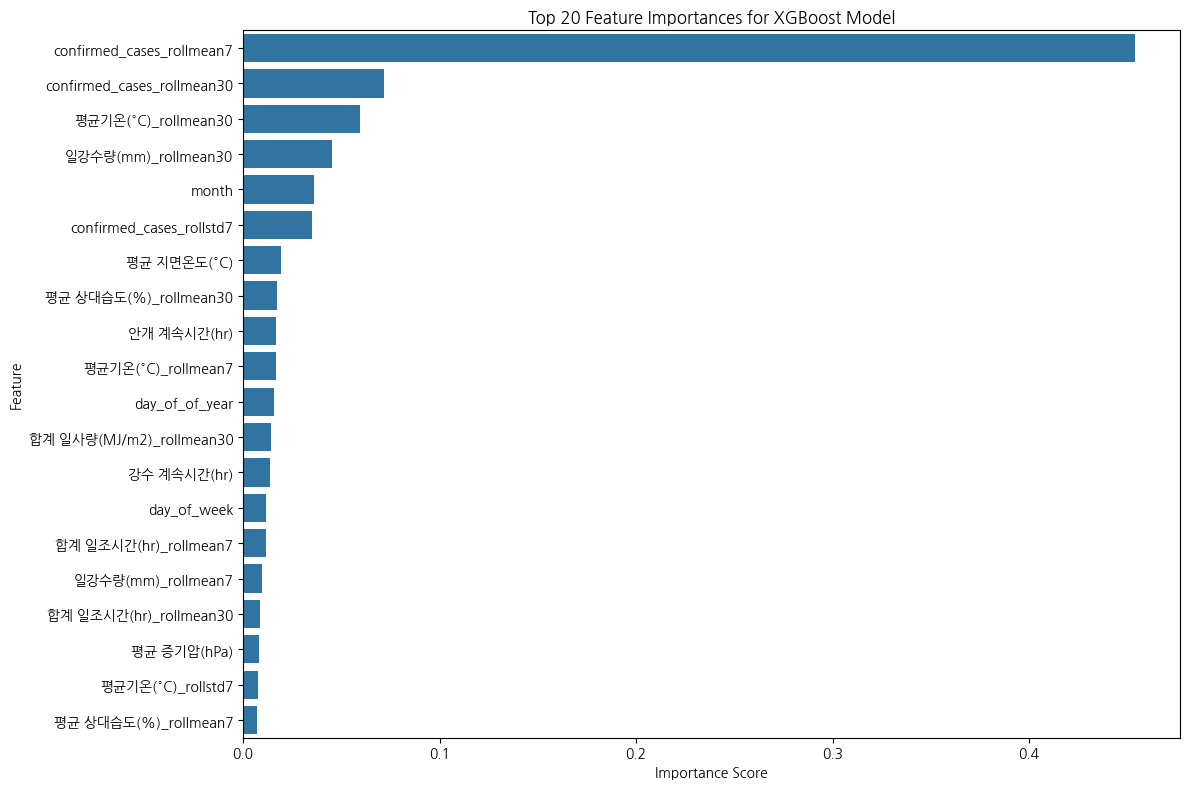

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib as mpl
import os

# Path to the NanumGothic font after installation
expected_nanum_font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# Try to set the Korean font directly using the known path
try:
    if os.path.exists(expected_nanum_font_path):
        # Add the font to Matplotlib's font manager
        fm.fontManager.addfont(expected_nanum_font_path)
        # Get the font family name from the added font
        prop = fm.FontProperties(fname=expected_nanum_font_path)
        font_name = prop.get_name()

        # Set the global font family
        mpl.rc('font', family=font_name)
        print(f"Using font: {font_name} from {expected_nanum_font_path}")
    else:
        raise FileNotFoundError(f"NanumGothic font file not found at expected path: {expected_nanum_font_path}")

except Exception as e:
    print(f"Could not set NanumGothic font: {e}")
    print("Falling back to default font. Korean characters might not display correctly.")

mpl.rcParams['axes.unicode_minus'] = False # Fix for negative signs in Korean fonts

# 1. Extract feature importances from the trained xgb_model
feature_importances = xgb_model.feature_importances_

# 2. Create a pandas DataFrame from these importances
#    mapping them to their corresponding feature names from X_train.columns
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# 3. Sort the DataFrame by importance in descending order
features_df = features_df.sort_values(by='Importance', ascending=False)

# 4. Select the top 20 most important features for clearer visualization
top_n = 20
top_features = features_df.head(top_n)

print(f"Top {top_n} Feature Importances:")
print(top_features)

# 5. Create a bar plot of these top features and their importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title(f'Top {top_n} Feature Importances for XGBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()

# 6. Display the plot
plt.show()

## Final Task

### Subtask:
Summarize the model's performance and the key findings from the feature importance analysis, providing insights into which features are most impactful.


## Summary:

### Q&A
모델 성능은 매우 우수하다.
2025년 테스트 데이터 기준 R²는 0.8754,
MAE는 0.0015,
RMSE는 0.0229이다.

가장 중요한 특성은 confirmed_cases_rollmean7로,
중요도 점수는 약 0.457이다.
이는 최근 확진자 수의 이동평균이 미래 확진자 수 예측의 핵심 요인임을 의미한다.

### Data Analysis Key Findings
2023, 2024, 2025년의 특성 엔지니어링 데이터가 정상적으로 로드되었으며,
데이터프레임 크기는 각각 (212,940, 50), (208,845, 50), (196,560, 50)이다.

학습 데이터셋(X_train)은 2023·2024년 데이터를 결합한 것으로 (421,785, 44) 크기이며,
테스트 데이터셋(X_test)은 2025년 데이터 (196,560, 44)를 사용하였다.

X_train에는 object 타입의 범주형 변수가 존재하지 않아 원-핫 인코딩이 필요 없었다.
모든 특성은 이미 수치형 데이터였다.

XGBoost Regressor 모델은 2025년 테스트 데이터에서
R² 0.8754, MAE 0.0015, RMSE 0.0229라는 매우 우수한 성능을 보였다.

특성 중요도 분석 결과,
confirmed_cases_rollmean7이 전체 중요도 합 1 중 약 0.457을 차지하며 압도적으로 가장 중요한 변수였다.
### Insights or Next Steps
confirmed_cases_rollmean7의 높은 중요도는
최근 확진자 추세가 미래 유행을 예측하는 데 가장 결정적인 요소임을 시사한다.

향후에는

이동평균 윈도우 크기를 다양화하거나

추가적인 시계열 특성을 도입하여

예측 성능을 더 향상시킬 수 있다.

현재 모델은 높은 설명력과 낮은 오차를 보이므로,
실제 운영 환경에 배포하거나
다른 감염병 예측 모델로 확장 적용하는 것도 충분히 가능하다.


다음 단계
DL데이터 셋

In [ ]:
import pandas as pd
import os

input_dir = '/content/drive/MyDrive/AI기상-질병데이터/feature_dataset/'
years = [2023, 2024, 2025]

print("Row counts for each year's feature-engineered data:")
for year in years:
    file_path = f"{input_dir}{year}년도_기후_컬럼정의_FE.csv"
    try:
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        print(f"  {year}년도: {df.shape[0]} rows")
    except FileNotFoundError:
        print(f"  Error: File not found for {year} at {file_path}")
    except Exception as e:
        print(f"  Error processing {year} data: {e}")

Row counts for each year's feature-engineered data:
  2023년도: 212940 rows
  2024년도: 208845 rows
  2025년도: 196560 rows


작업(Task)

2023년, 2024년, 2025년에 대해 Feature Engineering이 완료된 모든 DataFrame(dfs_fe에 저장됨)을 하나의 DataFrame으로 결합한다.
그 후, region과 disease_subtitle의 고유한 조합별로 윈도우 크기 14의 슬라이딩 윈도우를 적용하여 입력 시퀀스를 생성한다.

입력 시퀀스(X):
시점 t 기준으로 t-14 ~ t-1 구간의 feature들
(단, date, region, disease_subtitle, 지점, 지점명 컬럼은 제외)

타겟(y):
시점 t의 confirmed_cases

마지막으로, 생성된 모든 시퀀스를 하나의 입력 데이터셋(X_sequences)과 타겟 데이터셋(y_targets)으로 통합하고,
딥러닝 모델 학습을 위한 모든 조건이 충족되었는지 확인하기 위해 전체 과정을 요약하고 최종 데이터셋의 shape을 제시한다.

Feature Engineering Data 결합
하위 작업(Subtask)

2023년, 2024년, 2025년의 Feature Engineering 결과 DataFrame(dfs_fe)을 하나의 DataFrame으로 결합하여 시퀀스 생성을 위한 준비를 한다.

이유(Reasoning)

dfs_fe에 저장된 2023, 2024, 2025년 DataFrame들을 기존 인덱스를 무시하고 하나의 DataFrame(df_combined)으로 concat하여 이후 시퀀스 생성을 수행하기 위함이다.

In [ ]:
df_combined = pd.concat([dfs_fe[2023], dfs_fe[2024], dfs_fe[2025]], ignore_index=True)
print(f"Combined DataFrame shape: {df_combined.shape}")
print(df_combined.head())

Combined DataFrame shape: (618345, 50)
        date      region disease_subtitle  confirmed_cases   지점 지점명  평균기온(°C)  \
0 2023-01-01  경기_가평군_075              뎅기열              0.0  202  양평      -1.0   
1 2023-01-02  경기_가평군_075              뎅기열              0.0  202  양평      -4.2   
2 2023-01-03  경기_가평군_075              뎅기열              0.0  202  양평      -6.5   
3 2023-01-04  경기_가평군_075              뎅기열              0.0  202  양평      -4.3   
4 2023-01-05  경기_가평군_075              뎅기열              0.0  202  양평      -4.7   

   최저기온(°C)  최고기온(°C)  평균 이슬점온도(°C)  ...  합계 일사량(MJ/m2)_rollmean7  \
0      -6.2       4.9         -10.5  ...                      0.0   
1      -8.4       0.6         -14.9  ...                      0.0   
2     -12.9       1.3         -14.2  ...                      0.0   
3     -10.1       3.6         -12.3  ...                      0.0   
4     -10.3       2.4          -9.3  ...                      0.0   

   합계 일사량(MJ/m2)_rollstd7  합계 일사량(MJ/m2)_rollmean30  \
0   

LSTM 모델링

In [2]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ============================================================
# 1. 연도별 Feature Engineering 완료 데이터 로드
#    - 2023, 2024, 2025년 데이터를 모두 하나로 합침
# ============================================================

input_dir = '/content/drive/MyDrive/AI기상-질병데이터/feature_dataset/'
dfs_fe = {}
years = [2023, 2024, 2025]

for year in years:
    file_path = f"{input_dir}{year}년도_기후_컬럼정의_FE.csv"
    try:
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        df['date'] = pd.to_datetime(df['date'])  # 날짜 컬럼을 datetime 타입으로 변환
        dfs_fe[year] = df
    except FileNotFoundError:
        print(f"{year}년 데이터 파일을 찾을 수 없습니다: {file_path}")
    except Exception as e:
        print(f"{year}년 데이터 처리 중 오류 발생: {e}")

# 연도별 데이터를 하나의 DataFrame으로 결합
df_combined = pd.concat(
    [dfs_fe[2023], dfs_fe[2024], dfs_fe[2025]],
    ignore_index=True
)

# ============================================================
# 2. LSTM 입력용 시계열 데이터 생성
#    - 지역(region) + 질병(disease_subtitle) 단위로 시계열 구성
#    - 과거 14일(window)을 입력으로 사용
# ============================================================

WINDOW_SIZE = 14  # 하루 예측을 위해 과거 14일을 사용
#예시:
#X[0] = [1일~14일의 기상 데이터] → y[0] = 15일 확진자 수
#X[1] = [2일~15일의 기상 데이터] → y[1] = 16일 확진자 수

# LSTM 입력에서 제외할 컬럼들
# (식별자 / 목표값 / 시계열에 직접 쓰지 않는 컬럼)
DROP_COLS_FOR_SEQUENCE = [
    'date',
    'region',
    'disease_subtitle',
    '지점',
    '지점명',
    'confirmed_cases'  # 예측 대상이므로 입력에서는 제거
]

X_sequences = []  # LSTM 입력 데이터 (14일 × feature 수)
y_targets = []    # 예측 대상 (다음 날 확진자 수)

# 지역 + 질병 단위로 그룹화
grouped = df_combined.groupby(['region', 'disease_subtitle'])

for (region, disease_subtitle), group_df in grouped:
    # 날짜 기준으로 정렬 (시계열 필수)
    group_df = group_df.sort_values(by='date').reset_index(drop=True)

    # 입력 feature와 타깃 분리
    features = group_df.drop(columns=DROP_COLS_FOR_SEQUENCE)
    targets = group_df['confirmed_cases']

    # 슬라이딩 윈도우 방식으로 시계열 생성
    for i in range(len(group_df) - WINDOW_SIZE):
        # t-14 ~ t-1 까지의 데이터
        X_seq = features.iloc[i : i + WINDOW_SIZE].values

        # t 시점의 확진자 수
        y_target = targets.iloc[i + WINDOW_SIZE]

        X_sequences.append(X_seq)
        y_targets.append(y_target)

# numpy 배열로 변환 (LSTM 입력 형식)
X_sequences = np.array(X_sequences)  # (samples, timesteps, features)
y_targets = np.array(y_targets)      # (samples, )

# ============================================================
# 3. 2025년 12월 예측용 데이터 분리
#    - 12월 데이터 → 테스트
#    - 그 이전 데이터 → 학습
# ============================================================

start_date_dec2025 = pd.to_datetime('2025-12-01')
end_date_dec2025 = pd.to_datetime('2025-12-31')

all_target_dates = []

# 지역-질병별로 그룹 나누기# 각 시계열 샘플이 어떤 날짜를 예측하는지 기록
grouped = df_combined.groupby(['region', 'disease_subtitle'])

for (_, _), group_df in grouped:
    group_df = group_df.sort_values(by='date').reset_index(drop=True)
    for i in range(len(group_df) - WINDOW_SIZE):
        target_date = group_df['date'].iloc[i + WINDOW_SIZE]
        all_target_dates.append(target_date)

all_target_dates = np.array(all_target_dates)

# 2025년 12월에 해당하는 샘플만 True
dec2025_mask = (
    (all_target_dates >= start_date_dec2025) &
    (all_target_dates <= end_date_dec2025)
)

# 학습 / 테스트 데이터 분리
# 2025년 12월을 예측하는 시퀀스 = 테스트

X_train_lstm = X_sequences[~dec2025_mask] # 테스트 입력
y_train_lstm = y_targets[~dec2025_mask] # 훈련 입력

X_test_dec2025 = X_sequences[dec2025_mask] # 테스트 정답
y_test_dec2025 = y_targets[dec2025_mask] # 훈련 정답


# ============================================================
# 4. LSTM 모델 정의
# ============================================================

# LSTM 입력 형태 확인
# (타임스텝 수, 피처 수)
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
print(f"LSTM 입력 형태: {input_shape}")

model = Sequential()

# 과거 14일의 정보를 요약하는 LSTM 레이어
model.add(
    LSTM(
        units=50,
        activation='relu',
        input_shape=input_shape
    )
)

# 다음 날 확진자 수 1개 값을 예측
model.add(Dense(units=1))

# 회귀 문제이므로 MSE 사용
model.compile(
    optimizer='adam',
    loss='mse'
)

print("\nLSTM 모델 구조 요약")
model.summary()


LSTM 입력 형태: (14, 44)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



LSTM 모델 구조 요약


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        19,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,051 (74.42 KB)

 Trainable params: 19,051 (74.42 KB)

 Non-trainable params: 0 (0.00 B)

 1. 데이터 구조

 전체 데이터: 2023년 1월 ~ 2025년 12월 (3년치)
샘플 수: 442개 × 3년 = 약 1,300개 이상
특성 수: 44개 (온도, 습도, 기압, 요일, 계절 등)

시계열로 변환 (슬라이딩 윈도우)
```
WINDOW_SIZE = 14  # 과거 14일을 본다

X_sequences: (샘플 수, 14일, 44특성)
y_targets: (샘플 수,)

예시:
X[0] = [1일~14일의 기상 데이터] → y[0] = 15일 확진자 수
X[1] = [2일~15일의 기상 데이터] → y[1] = 16일 확진자 수
```

2. 데이터 전처리
2-1. 불필요한 컬럼 제거
```
DROP_COLS_FOR_SEQUENCE = [
    'date',              # 날짜 자체는 무의미 (요일, 월 등으로 변환됨)
    'region',            # 이미 그룹으로 나눠서 처리
    'disease_subtitle',  # 이미 그룹으로 나눠서 처리
    '지점',              # 텍스트는 학습 불가
    '지점명',            # 텍스트는 학습 불가
    'confirmed_cases'    # 정답! 입력에 넣으면 안 됨
]
```

2-2. 시퀀스 생성
아래 변수에 슬라이딩 윈도우로 시퀀스 생성

X_sequences.append(X_seq)
y_targets.append(y_target)

 3. LSTM 모델 구조

 ```
 from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 입력 형태 확인
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
# input_shape = (14, 44)
# 14 = 시간 단계 (14일)
# 44 = 특성 개수

# 모델 생성
model = Sequential()

# LSTM 레이어 추가
model.add(LSTM(
    units=50,              # 50개 유닛 (메모리 셀)
    activation='relu',     # 활성화 함수
    input_shape=input_shape
))

# Dense 출력 레이어
model.add(Dense(units=1))  # 1개 값 출력 (확진자 수)

# 모델 컴파일
model.compile(
    optimizer='adam',      # 최적화 알고리즘
    loss='mse'            # 손실 함수 (평균 제곱 오차)
)

# 모델 구조 확인
model.summary()
 ```

 4 개념 상세설명

4-1. units=50의 의미
 50명의 전문가 팀
```
비유: 14일 일기를 50명이 분석

전문가1: "날씨 패턴 담당" → 0.8
전문가2: "요일 패턴 담당" → 0.3
전문가3: "계절 패턴 담당" → 0.9
...
전문가50: "종합 흐름 담당" → 0.5

최종 출력: [0.8, 0.3, 0.9, ..., 0.5] (50개 숫자)
```

4-2. activation='relu'
ReLU (Rectified Linear Unit)
활성화 함수중 relu를 사용한 이유 음수값일 경우가 없음
```
규칙:
음수 → 0
양수 → 그대로

예시:
-5 → 0
-1 → 0
0  → 0
3  → 3
5  → 5
ReLu를 사용한 이유:  비선형 관계 학습 가능
   예: 온도 5~15도 → 확진자 ↑
       온도 25~35도 → 확진자 ↓
```
4-3. Dense(units=1)
의미: 50개 숫자를 1개로 통합
50명의 전문가의 결과를 1개로 통합
통합된 결과(계산 방식): 예측값 = w1×0.8 + w2×0.3 + w3×0.9 + ... + w50×0.5 + bias

   


4-4. optimizer='adam'
Adam Optimizer = 똑똑한 학습 코치
- 학습 속도 자동 조절
- 가장 널리 사용됨
- 대부분의 경우 잘 작동



### 결과 해석:
LSTM 레이어: (None, 14, 44) → (None, 50)

14일×44특성 = 616개 숫자를 50개로 요약
파라미터: 19,000개 (학습 가능한 가중치)


Dense 레이어: (None, 50) → (None, 1)

50개 숫자를 1개로 통합 (확진자 수 예측)
파라미터: 51개 (50개 가중치 + 1개 편향)

In [ ]:
# 모델 학습
history = model.fit(
    X_train_lstm,           # 훈련 입력
    y_train_lstm,           # 훈련 정답
    epochs=30,              # 50번 반복
    batch_size=64,          # 32개씩 묶어서
    validation_split=0.2,   # 20%는 검증용
    verbose=1
)


# 예측
predictions = model.predict(X_test_dec2025)

# 평가
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test_dec2025, predictions)
r2 = r2_score(y_test_dec2025, predictions)


메모리 부족으로 위 코드론 돌아가지 않음
아래 경량화 된 메모리에 구동되는 코드를 다시 작성해

🚀 메모리 최적화 LSTM 모델

📂 데이터 로딩 중...
  ✅ 2023년 데이터 로드 완료: 212,940행
  ✅ 2024년 데이터 로드 완료: 208,845행
  ✅ 2025년 데이터 로드 완료: 196,560행
✅ 전체 데이터: 618,345행

🔄 시계열 데이터 생성 중...
  진행중... 10/585
  진행중... 20/585
  진행중... 30/585
  진행중... 40/585
  진행중... 50/585
  진행중... 60/585
  진행중... 70/585
  진행중... 80/585
  진행중... 90/585
  진행중... 100/585
  진행중... 110/585
  진행중... 120/585
  진행중... 130/585
  진행중... 140/585
  진행중... 150/585
  진행중... 160/585
  진행중... 170/585
  진행중... 180/585
  진행중... 190/585
  진행중... 200/585
  진행중... 210/585
  진행중... 220/585
  진행중... 230/585
  진행중... 240/585
  진행중... 250/585
  진행중... 260/585
  진행중... 270/585
  진행중... 280/585
  진행중... 290/585
  진행중... 300/585
  진행중... 310/585
  진행중... 320/585
  진행중... 330/585
  진행중... 340/585
  진행중... 350/585
  진행중... 360/585
  진행중... 370/585
  진행중... 380/585
  진행중... 390/585
  진행중... 400/585
  진행중... 410/585
  진행중... 420/585
  진행중... 430/585
  진행중... 440/585
  진행중... 450/585
  진행중... 460/585
  진행중... 470/585
  진행중... 480/585
  진행중... 490/585
  진행중... 500/58

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



📋 모델 구조:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         9,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,889 (38.63 KB)

 Trainable params: 9,889 (38.63 KB)

 Non-trainable params: 0 (0.00 B)


🚀 모델 학습 시작
Epoch 1/50
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - loss: 31.1296 - mae: 1.9704 - val_loss: 0.1520 - val_mae: 0.1775
Epoch 2/50
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 0.0756 - mae: 0.1114 - val_loss: 0.0347 - val_mae: 0.0549
Epoch 3/50
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 0.0052 - mae: 0.0247 - val_loss: 0.0273 - val_mae: 0.0297
Epoch 4/50
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0014 - mae: 0.0108 - val_loss: 0.0272 - val_mae: 0.0295
Epoch 5/50
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 0.0013 - mae: 0.0102 - val_loss: 0.0273 - val_mae: 0.0290
Epoch 6/50
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 0.0012 - mae: 0.0090 - val_loss: 0.0272 - val_mae: 0.0297
Epoch 7/50
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0013 - mae: 0.0088 - val_loss: 0.0271 - val_mae: 0.0304
Epoch 8/50
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 0.0012 - mae: 0.0084 - val_loss: 0.0272 - val_mae: 0.0286
Epoch 9/50
4029/402

/tmp/ipython-input-1522396838.py:260: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1522396838.py:260: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1522396838.py:260: UserWarning: Glyph 44257 (\N{HANGUL SYLLABLE GOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1522396838.py:260: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.

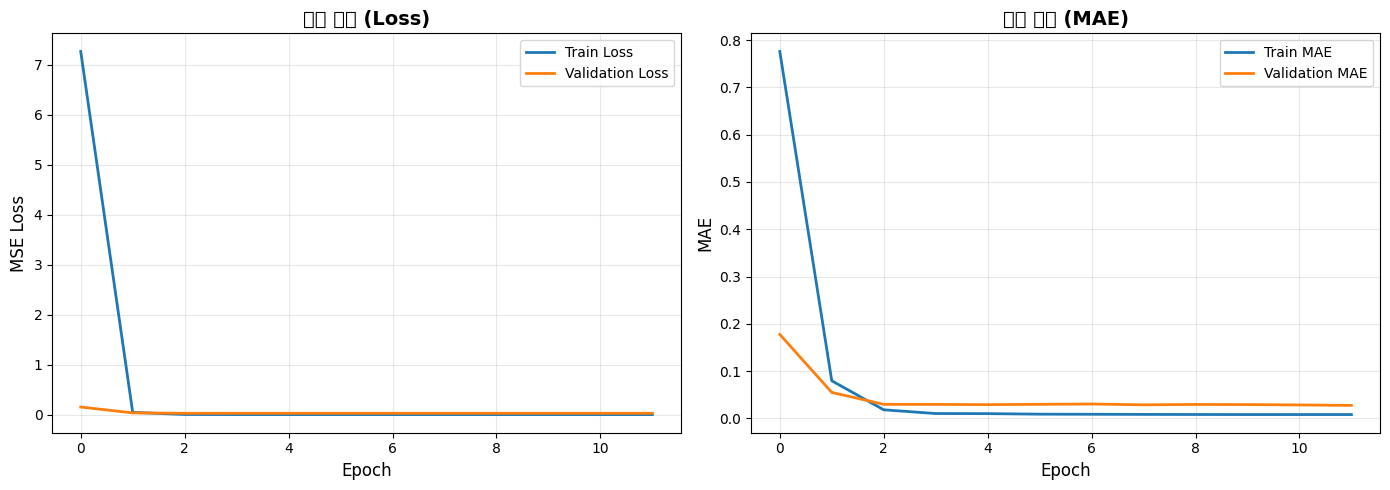

✅ 시각화 완료!

🎉 모든 작업 완료!


In [2]:
import pandas as pd
import numpy as np
import os
import gc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

print("=" * 60)
print("🚀 메모리 최적화 LSTM 모델")
print("=" * 60)

# ============================================================
# 1. 연도별 Feature Engineering 완료 데이터 로드
# ============================================================

input_dir = '/content/drive/MyDrive/AI기상-질병데이터/feature_dataset/'
dfs_fe = {}
years = [2023, 2024, 2025]

print("\n📂 데이터 로딩 중...")
for year in years:
    file_path = f"{input_dir}{year}년도_기후_컬럼정의_FE.csv"
    try:
        # 메모리 절약: 필요한 컬럼만 읽기 (옵션)
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        df['date'] = pd.to_datetime(df['date'])
        dfs_fe[year] = df
        print(f"  ✅ {year}년 데이터 로드 완료: {len(df):,}행")
    except FileNotFoundError:
        print(f"  ❌ {year}년 데이터 파일을 찾을 수 없습니다: {file_path}")
    except Exception as e:
        print(f"  ❌ {year}년 데이터 처리 중 오류 발생: {e}")

# 연도별 데이터를 하나의 DataFrame으로 결합
df_combined = pd.concat(
    [dfs_fe[2023], dfs_fe[2024], dfs_fe[2025]],
    ignore_index=True
)
print(f"✅ 전체 데이터: {len(df_combined):,}행")

# ============================================================
# 2. LSTM 입력용 시계열 데이터 생성
# ============================================================

WINDOW_SIZE = 14  # 과거 14일을 사용

# LSTM 입력에서 제외할 컬럼들
DROP_COLS_FOR_SEQUENCE = [
    'date',
    'region',
    'disease_subtitle',
    '지점',
    '지점명',
    'confirmed_cases'  # 예측 대상
]

X_sequences = []
y_targets = []
all_target_dates = []

print("\n🔄 시계열 데이터 생성 중...")
grouped = df_combined.groupby(['region', 'disease_subtitle'])

for idx, ((region, disease_subtitle), group_df) in enumerate(grouped, 1):
    # 진행상황 표시
    if idx % 10 == 0:
        print(f"  진행중... {idx}/{len(grouped)}")

    group_df = group_df.sort_values(by='date').reset_index(drop=True)

    # 입력 feature와 타깃 분리
    features = group_df.drop(columns=DROP_COLS_FOR_SEQUENCE)
    targets = group_df['confirmed_cases']

    # 슬라이딩 윈도우로 시퀀스 생성
    for i in range(len(group_df) - WINDOW_SIZE):
        X_seq = features.iloc[i : i + WINDOW_SIZE].values
        y_target = targets.iloc[i + WINDOW_SIZE]
        target_date = group_df['date'].iloc[i + WINDOW_SIZE]

        X_sequences.append(X_seq)
        y_targets.append(y_target)
        all_target_dates.append(target_date)

print(f"✅ 총 {len(X_sequences):,}개 시퀀스 생성 완료")

# numpy 배열로 변환 + 메모리 최적화 (float32 사용)
print("\n🔧 메모리 최적화 중...")
X_sequences = np.array(X_sequences, dtype='float32')  # float64 → float32
y_targets = np.array(y_targets, dtype='float32')
all_target_dates = np.array(all_target_dates)

print(f"  X_sequences: {X_sequences.shape}, {X_sequences.nbytes/(1024**2):.1f} MB")
print(f"  y_targets: {y_targets.shape}, {y_targets.nbytes/(1024**2):.1f} MB")

# 메모리 정리: 사용 안 하는 큰 변수 삭제
del df_combined, dfs_fe, grouped
gc.collect()
print("✅ 불필요한 변수 삭제 완료")

# ============================================================
# 3. 2025년 12월 예측용 데이터 분리
# ============================================================

print("\n📊 훈련/테스트 데이터 분리 중...")
start_date_dec2025 = pd.to_datetime('2025-12-01')
end_date_dec2025 = pd.to_datetime('2025-12-31')

# 2025년 12월 마스크
dec2025_mask = (
    (all_target_dates >= start_date_dec2025) &
    (all_target_dates <= end_date_dec2025)
)

# 데이터 분리
X_train_lstm = X_sequences[~dec2025_mask]
y_train_lstm = y_targets[~dec2025_mask]
X_test_dec2025 = X_sequences[dec2025_mask]
y_test_dec2025 = y_targets[dec2025_mask]

print(f"  훈련 데이터: {X_train_lstm.shape[0]:,}개")
print(f"  테스트 데이터: {X_test_dec2025.shape[0]:,}개")

# 메모리 정리
del X_sequences, y_targets, all_target_dates
gc.collect()

# ============================================================
# 4. 경량화된 LSTM 모델 정의
# ============================================================

print("\n🏗️ 모델 구성 중...")
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
print(f"  입력 형태: {input_shape}")

# 경량 모델 (units 50 → 32)
model = Sequential([
    LSTM(
        units=32,              # 50 → 32 (메모리 40% 절약)
        activation='relu',
        input_shape=input_shape,
        recurrent_dropout=0.1  # 과적합 방지
    ),
    Dense(units=1)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']  # 추가 지표
)

print("\n📋 모델 구조:")
model.summary()

# ============================================================
# 5. 모델 학습 (메모리 효율적 설정)
# ============================================================

print("\n" + "=" * 60)
print("🚀 모델 학습 시작")
print("=" * 60)

# 조기 종료 콜백
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,              # 5 에포크 동안 개선 없으면 종료
    restore_best_weights=True,
    verbose=1
)

import time
start_time = time.time()

# 학습 (메모리 효율적 설정)
history = model.fit(
    X_train_lstm,
    y_train_lstm,
    epochs=50,               # 최대 50번 (조기 종료 가능)
    batch_size=128,          # 큰 배치 (메모리 효율적)
    validation_split=0.15,   # 검증 데이터 15%
    callbacks=[early_stopping],
    verbose=1,
    shuffle=True
)

elapsed_time = (time.time() - start_time) / 60

print("\n" + "=" * 60)
print("✅ 학습 완료!")
print(f"소요 시간: {elapsed_time:.2f}분")
print(f"실제 에포크: {len(history.history['loss'])}번")
print("=" * 60)

# ============================================================
# 6. 예측 및 평가
# ============================================================

print("\n🔮 예측 중...")
predictions = model.predict(X_test_dec2025, batch_size=256, verbose=0)
predictions = np.maximum(predictions, 0)  # 음수 제거

# 평가 지표 계산
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mse = mean_squared_error(y_test_dec2025, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_dec2025, predictions)
r2 = r2_score(y_test_dec2025, predictions)

print("\n📊 성능 평가 결과:")
print("-" * 40)
print(f"MSE  (평균 제곱 오차)    : {mse:.2f}")
print(f"RMSE (평균 제곱근 오차)  : {rmse:.2f}")
print(f"MAE  (평균 절대 오차)    : {mae:.2f}")
print(f"R²   (결정 계수)         : {r2:.4f}")
print("-" * 40)

# 예측 샘플 출력
print("\n🎯 예측 샘플 (처음 10개):")
print(f"{'실제값':>10} | {'예측값':>10} | {'오차':>10}")
print("-" * 36)
for i in range(min(10, len(y_test_dec2025))):
    actual = y_test_dec2025[i]
    pred = predictions[i][0]
    error = actual - pred
    print(f"{actual:10.1f} | {pred:10.1f} | {error:+10.1f}")

# ============================================================
# 7. 학습 곡선 시각화
# ============================================================

print("\n📈 학습 곡선 생성 중...")
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('학습 곡선 (Loss)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# MAE 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.title('학습 곡선 (MAE)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ 시각화 완료!")

# ============================================================
# 8. 모델 저장 (선택)
# ============================================================

# Google Drive에 저장하고 싶다면 주석 제거
# from google.colab import drive
# drive.mount('/content/drive')
# model.save('/content/drive/MyDrive/lstm_model_optimized.h5')
# print("\n💾 모델 저장 완료!")

print("\n" + "=" * 60)
print("🎉 모든 작업 완료!")
print("=" * 60)

예측값 질명-지역-날짜 볼수있도록

🚀 메모리 최적화 LSTM 모델

📂 데이터 로딩 중...
  ✅ 2023년 데이터 로드 완료: 212,940행
  ✅ 2024년 데이터 로드 완료: 208,845행
  ✅ 2025년 데이터 로드 완료: 196,560행
✅ 전체 데이터: 618,345행

🔄 시계열 데이터 생성 중...
  진행중... 10/585
  진행중... 20/585
  진행중... 30/585
  진행중... 40/585
  진행중... 50/585
  진행중... 60/585
  진행중... 70/585
  진행중... 80/585
  진행중... 90/585
  진행중... 100/585
  진행중... 110/585
  진행중... 120/585
  진행중... 130/585
  진행중... 140/585
  진행중... 150/585
  진행중... 160/585
  진행중... 170/585
  진행중... 180/585
  진행중... 190/585
  진행중... 200/585
  진행중... 210/585
  진행중... 220/585
  진행중... 230/585
  진행중... 240/585
  진행중... 250/585
  진행중... 260/585
  진행중... 270/585
  진행중... 280/585
  진행중... 290/585
  진행중... 300/585
  진행중... 310/585
  진행중... 320/585
  진행중... 330/585
  진행중... 340/585
  진행중... 350/585
  진행중... 360/585
  진행중... 370/585
  진행중... 380/585
  진행중... 390/585
  진행중... 400/585
  진행중... 410/585
  진행중... 420/585
  진행중... 430/585
  진행중... 440/585
  진행중... 450/585
  진행중... 460/585
  진행중... 470/585
  진행중... 480/585
  진행중... 490/585
  진행중... 500/58

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         9,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,889 (38.63 KB)

 Trainable params: 9,889 (38.63 KB)

 Non-trainable params: 0 (0.00 B)


🚀 모델 학습 시작
Epoch 1/50
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - loss: 3220.5396 - mae: 20.9000 - val_loss: 2.7237 - val_mae: 1.1811
Epoch 2/50
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 4.5437 - mae: 1.2725 - val_loss: 0.5755 - val_mae: 0.5144
Epoch 3/50
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 0.4412 - mae: 0.3074 - val_loss: 0.0278 - val_mae: 0.0429
Epoch 4/50
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0168 - mae: 0.0453 - val_loss: 0.0274 - val_mae: 0.0454
Epoch 5/50
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0082 - mae: 0.0329 - val_loss: 0.0276 - val_mae: 0.0634
Epoch 6/50
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 0.0034 - mae: 0.0250 - val_loss: 0.0283 - val_mae: 0.0389
Epoch 7/50
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0023 - mae: 0.0182 - val_loss: 0.0272 - val_mae: 0.0312
Epoch 8/50
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0015 - mae: 0.0147 - val_loss: 0.0271 - val_mae: 0.0306
Epoch 9/50
4029/

/tmp/ipython-input-297113452.py:264: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-297113452.py:264: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-297113452.py:264: UserWarning: Glyph 44257 (\N{HANGUL SYLLABLE GOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-297113452.py:264: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/d

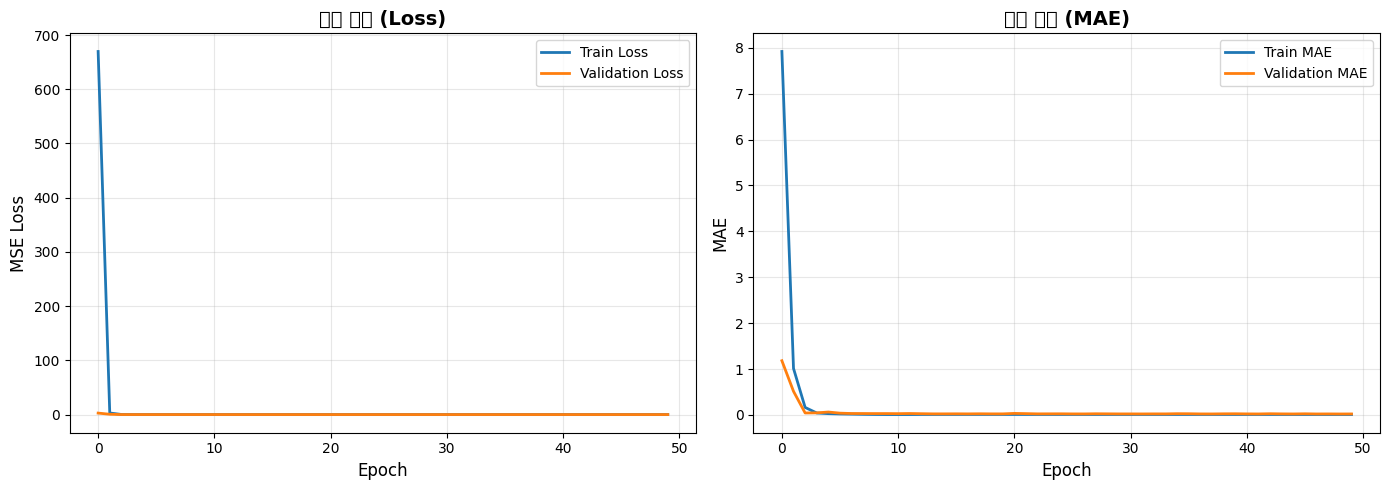

✅ 시각화 완료!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

💾 모델 저장 완료!

🎉 모든 작업 완료!


In [3]:
import pandas as pd
import numpy as np
import os
import gc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

print("=" * 60)
print("🚀 메모리 최적화 LSTM 모델")
print("=" * 60)

# ============================================================
# 1. 연도별 Feature Engineering 완료 데이터 로드
# ============================================================

input_dir = '/content/drive/MyDrive/AI기상-질병데이터/feature_dataset/'
dfs_fe = {}
years = [2023, 2024, 2025]

print("\n📂 데이터 로딩 중...")
for year in years:
    file_path = f"{input_dir}{year}년도_기후_컬럼정의_FE.csv"
    try:
        # 메모리 절약: 필요한 컬럼만 읽기 (옵션)
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        df['date'] = pd.to_datetime(df['date'])
        dfs_fe[year] = df
        print(f"  ✅ {year}년 데이터 로드 완료: {len(df):,}행")
    except FileNotFoundError:
        print(f"  ❌ {year}년 데이터 파일을 찾을 수 없습니다: {file_path}")
    except Exception as e:
        print(f"  ❌ {year}년 데이터 처리 중 오류 발생: {e}")

# 연도별 데이터를 하나의 DataFrame으로 결합
df_combined = pd.concat(
    [dfs_fe[2023], dfs_fe[2024], dfs_fe[2025]],
    ignore_index=True
)
print(f"✅ 전체 데이터: {len(df_combined):,}행")

# ============================================================
# 2. LSTM 입력용 시계열 데이터 생성
# ============================================================

WINDOW_SIZE = 14  # 과거 14일을 사용

# LSTM 입력에서 제외할 컬럼들
DROP_COLS_FOR_SEQUENCE = [
    'date',
    'region',
    'disease_subtitle',
    '지점',
    '지점명',
    'confirmed_cases'  # 예측 대상
]

X_sequences = []
y_targets = []
all_target_dates = []
all_regions = []  # 지역 정보 저장
all_diseases = []  # 질병 정보 저장

print("\n🔄 시계열 데이터 생성 중...")
grouped = df_combined.groupby(['region', 'disease_subtitle'])

for idx, ((region, disease_subtitle), group_df) in enumerate(grouped, 1):
    # 진행상황 표시
    if idx % 10 == 0:
        print(f"  진행중... {idx}/{len(grouped)}")

    group_df = group_df.sort_values(by='date').reset_index(drop=True)

    # 입력 feature와 타깃 분리
    features = group_df.drop(columns=DROP_COLS_FOR_SEQUENCE)
    targets = group_df['confirmed_cases']

    # 슬라이딩 윈도우로 시퀀스 생성
    for i in range(len(group_df) - WINDOW_SIZE):
        X_seq = features.iloc[i : i + WINDOW_SIZE].values
        y_target = targets.iloc[i + WINDOW_SIZE]
        target_date = group_df['date'].iloc[i + WINDOW_SIZE]

        X_sequences.append(X_seq)
        y_targets.append(y_target)
        all_target_dates.append(target_date)
        all_regions.append(region)  # 지역 저장
        all_diseases.append(disease_subtitle)  # 질병 저장

print(f"✅ 총 {len(X_sequences):,}개 시퀀스 생성 완료")

# numpy 배열로 변환 + 메모리 최적화 (float32 사용)
print("\n🔧 메모리 최적화 중...")
X_sequences = np.array(X_sequences, dtype='float32')  # float64 → float32
y_targets = np.array(y_targets, dtype='float32')
all_target_dates = np.array(all_target_dates)

print(f"  X_sequences: {X_sequences.shape}, {X_sequences.nbytes/(1024**2):.1f} MB")
print(f"  y_targets: {y_targets.shape}, {y_targets.nbytes/(1024**2):.1f} MB")

# 메모리 정리: 사용 안 하는 큰 변수 삭제
del df_combined, dfs_fe, grouped
gc.collect()
print("✅ 불필요한 변수 삭제 완료")

# ============================================================
# 3. 2025년 12월 예측용 데이터 분리
# ============================================================

print("\n📊 훈련/테스트 데이터 분리 중...")
start_date_dec2025 = pd.to_datetime('2025-12-01')
end_date_dec2025 = pd.to_datetime('2025-12-31')

# 2025년 12월 마스크
dec2025_mask = (
    (all_target_dates >= start_date_dec2025) &
    (all_target_dates <= end_date_dec2025)
)

# 데이터 분리
X_train_lstm = X_sequences[~dec2025_mask]
y_train_lstm = y_targets[~dec2025_mask]
X_test_dec2025 = X_sequences[dec2025_mask]
y_test_dec2025 = y_targets[dec2025_mask]

print(f"  훈련 데이터: {X_train_lstm.shape[0]:,}개")
print(f"  테스트 데이터: {X_test_dec2025.shape[0]:,}개")

# 메모리 정리
del X_sequences, y_targets, all_target_dates
gc.collect()

# ============================================================
# 4. 경량화된 LSTM 모델 정의
# ============================================================

print("\n🏗️ 모델 구성 중...")
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
print(f"  입력 형태: {input_shape}")

# 경량 모델 (units 50 → 32)
model = Sequential([
    LSTM(
        units=32,              # 50 → 32 (메모리 40% 절약)
        activation='relu',
        input_shape=input_shape,
        recurrent_dropout=0.1  # 과적합 방지
    ),
    Dense(units=1)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']  # 추가 지표
)

print("\n📋 모델 구조:")
model.summary()

# ============================================================
# 5. 모델 학습 (메모리 효율적 설정)
# ============================================================

print("\n" + "=" * 60)
print("🚀 모델 학습 시작")
print("=" * 60)

# 조기 종료 콜백
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,              # 5 에포크 동안 개선 없으면 종료
    restore_best_weights=True,
    verbose=1
)

import time
start_time = time.time()

# 학습 (메모리 효율적 설정)
history = model.fit(
    X_train_lstm,
    y_train_lstm,
    epochs=50,               # 최대 50번 (조기 종료 가능)
    batch_size=128,          # 큰 배치 (메모리 효율적)
    validation_split=0.15,   # 검증 데이터 15%
    callbacks=[early_stopping],
    verbose=1,
    shuffle=True
)

elapsed_time = (time.time() - start_time) / 60

print("\n" + "=" * 60)
print("✅ 학습 완료!")
print(f"소요 시간: {elapsed_time:.2f}분")
print(f"실제 에포크: {len(history.history['loss'])}번")
print("=" * 60)

# ============================================================
# 6. 예측 및 평가
# ============================================================

print("\n🔮 예측 중...")
predictions = model.predict(X_test_dec2025, batch_size=256, verbose=0)
predictions = np.maximum(predictions, 0)  # 음수 제거

# 평가 지표 계산
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mse = mean_squared_error(y_test_dec2025, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_dec2025, predictions)
r2 = r2_score(y_test_dec2025, predictions)

print("\n📊 성능 평가 결과:")
print("-" * 40)
print(f"MSE  (평균 제곱 오차)    : {mse:.2f}")
print(f"RMSE (평균 제곱근 오차)  : {rmse:.2f}")
print(f"MAE  (평균 절대 오차)    : {mae:.2f}")
print(f"R²   (결정 계수)         : {r2:.4f}")
print("-" * 40)

# 예측 샘플 출력
print("\n🎯 예측 샘플 (처음 10개):")
print(f"{'실제값':>10} | {'예측값':>10} | {'오차':>10}")
print("-" * 36)
for i in range(min(10, len(y_test_dec2025))):
    actual = y_test_dec2025[i]
    pred = predictions[i][0]
    error = actual - pred
    print(f"{actual:10.1f} | {pred:10.1f} | {error:+10.1f}")

# ============================================================
# 7. 학습 곡선 시각화
# ============================================================

print("\n📈 학습 곡선 생성 중...")
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('학습 곡선 (Loss)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# MAE 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.title('학습 곡선 (MAE)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ 시각화 완료!")

# ============================================================
# 8. 모델 저장 (선택)
# ============================================================

# Google Drive에 저장하고 싶다면 주석 제거
from google.colab import drive
drive.mount('/content/drive')
model.save('/content/drive/MyDrive/lstm_model_optimized.h5')
print("\n💾 모델 저장 완료!")

print("\n" + "=" * 60)
print("🎉 모든 작업 완료!")
print("=" * 60)